In this project, we will utilize pandas to analyze data, including value, risk, and return metrics, of the prominent 'FAANG' companies: Facebook, Apple, Amazon, Netflix, and Google. We will address several questions in this notebook:

1. What was the change in our stocks' prices over time?
2. What were the moving averages of our stocks?
3. What were the daily return averages of each stock?
4. What was the correlation between the daily returns of different stocks?
5. How much value do we put at risk by investing in a particular stock?
6. How can we attempt to predict future 'FAANG' stock behavior?

In [127]:
from __future__ import division
import pandas as pd
from pandas import Series,DataFrame
import numpy as np

#Visualisation imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from datetime import datetime
#Using yfinance to access Yahoo Historical Stocks
import yfinance as yf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

We will compare the five "FAANG" companies to analyze their average stock prices and returns. Our objective is to perform a risk assessment of the stocks in the last 365 days.

In [128]:
tickers = ['AAPL','GOOG','MSFT','AMZN','NFLX']

current_time = datetime.now()

# Date one year prior to current
one_year_prior = datetime(current_time.year-1,current_time.month,current_time.day) 

ticker_data = {}
for ticker in tickers:
    ticker_data[ticker] = yf.download(ticker,one_year_prior,current_time)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Here, we have compiled simple statistics regarding the stock price of Netflix in the previous year.

## Tech Stock Analysis: Price, Volume, Moving Averages, and Daily Return Visualization

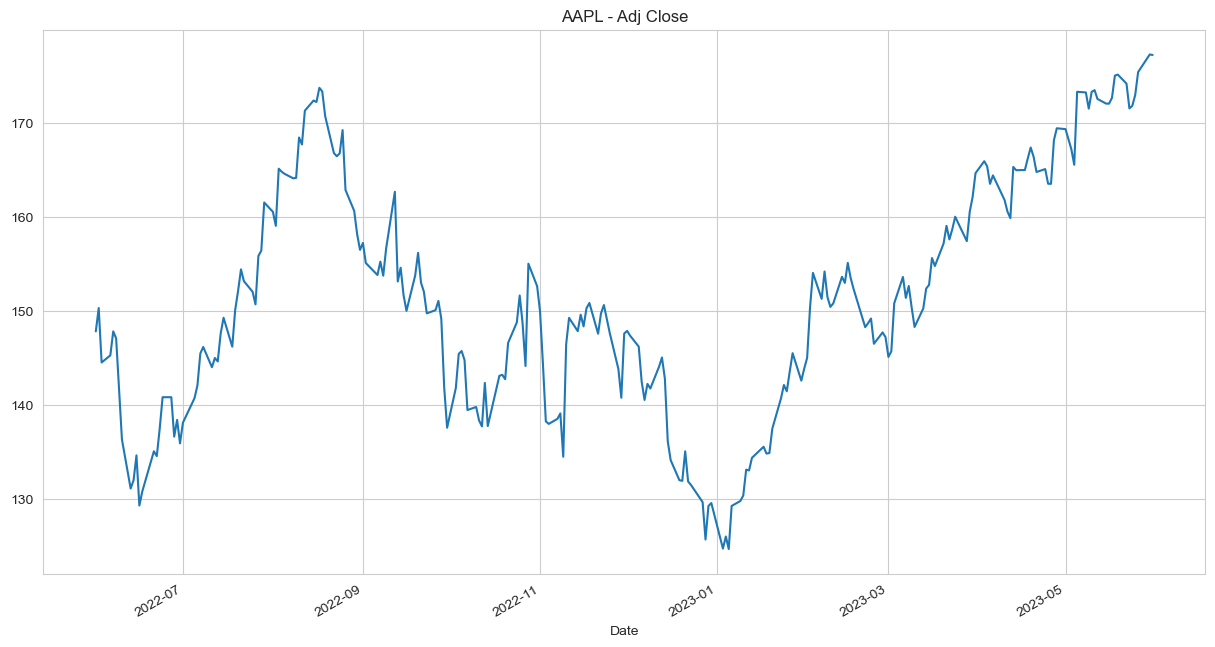

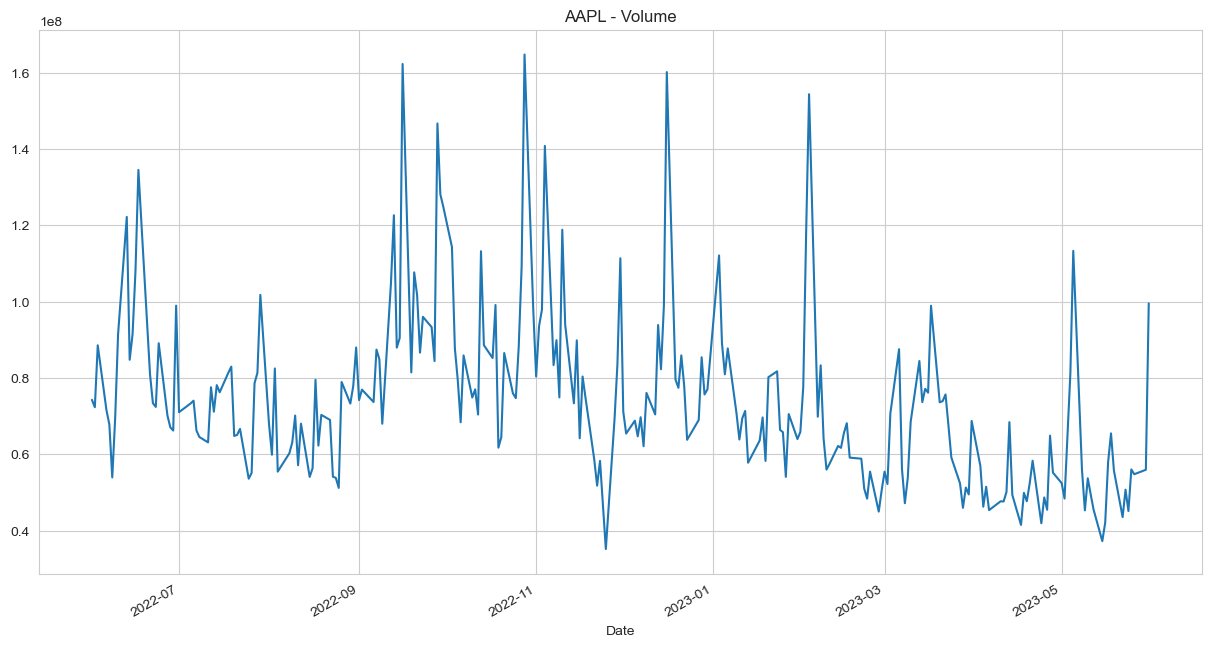

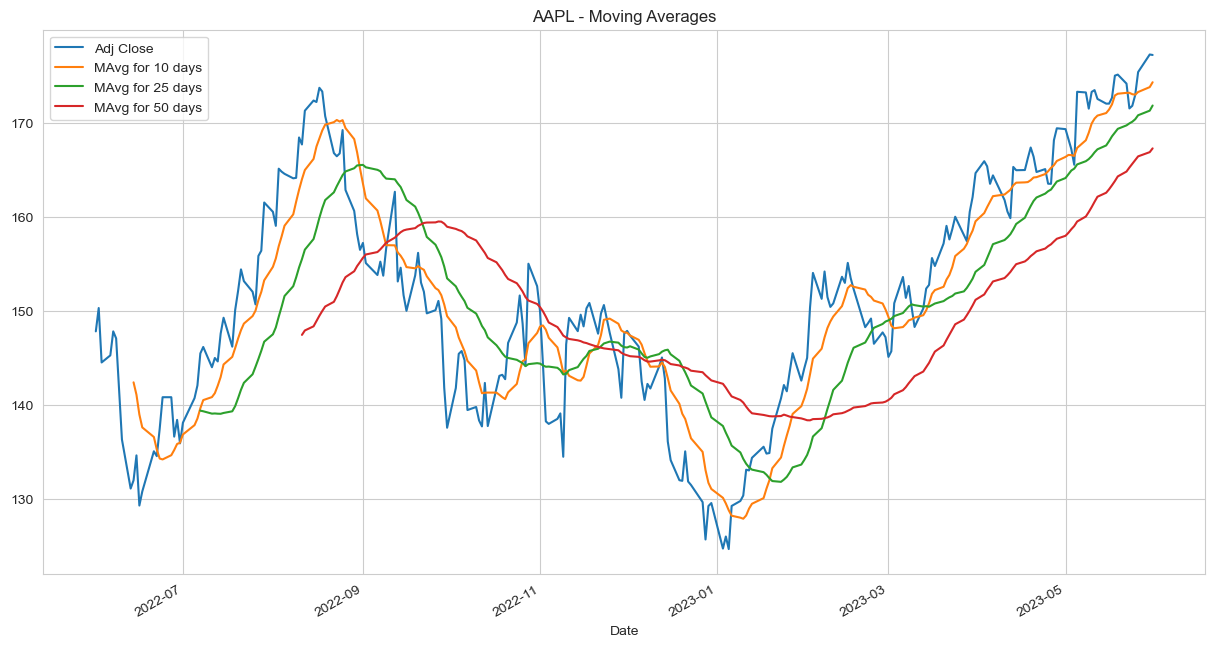

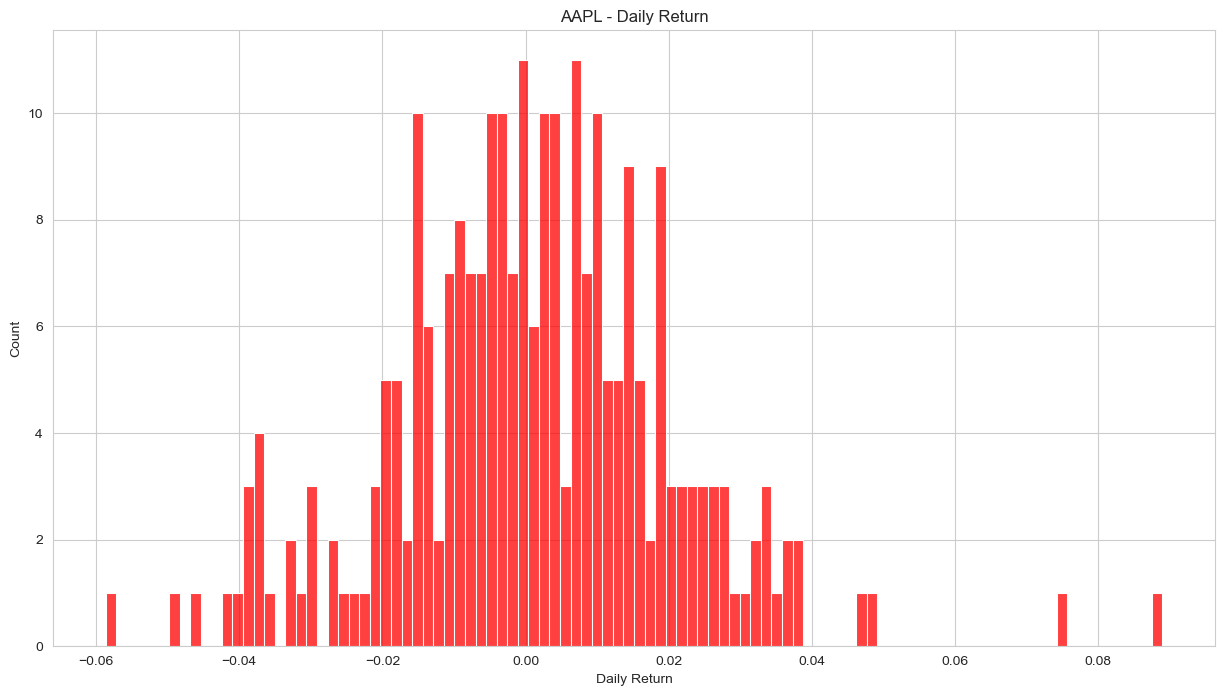

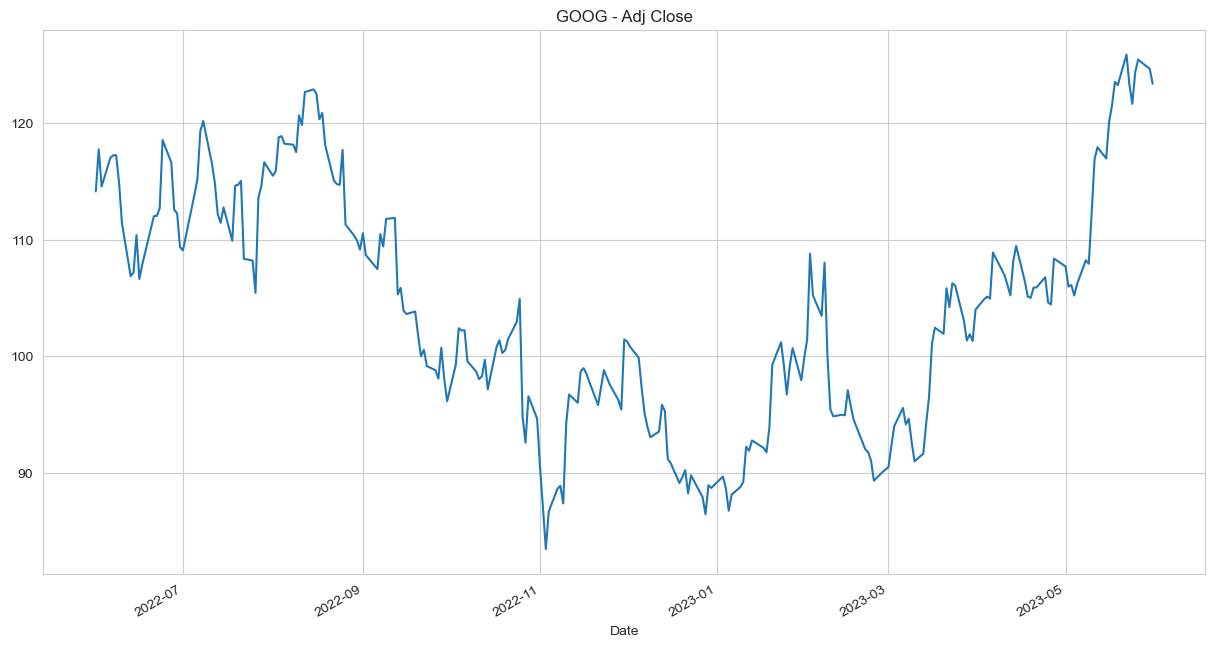

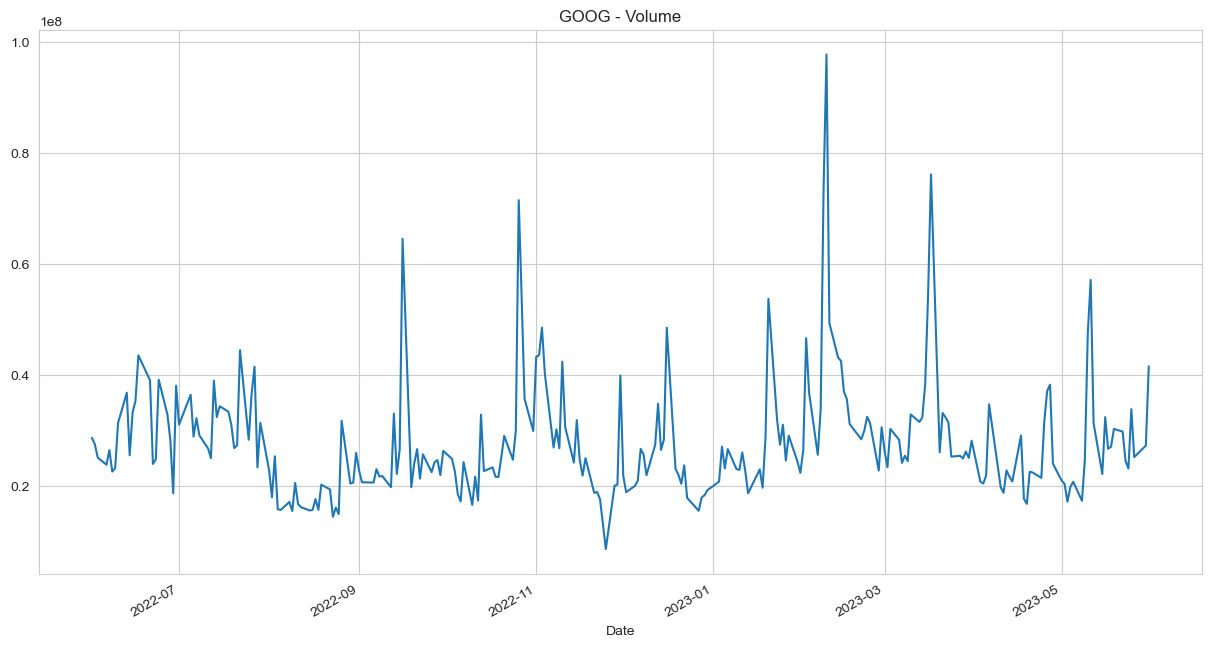

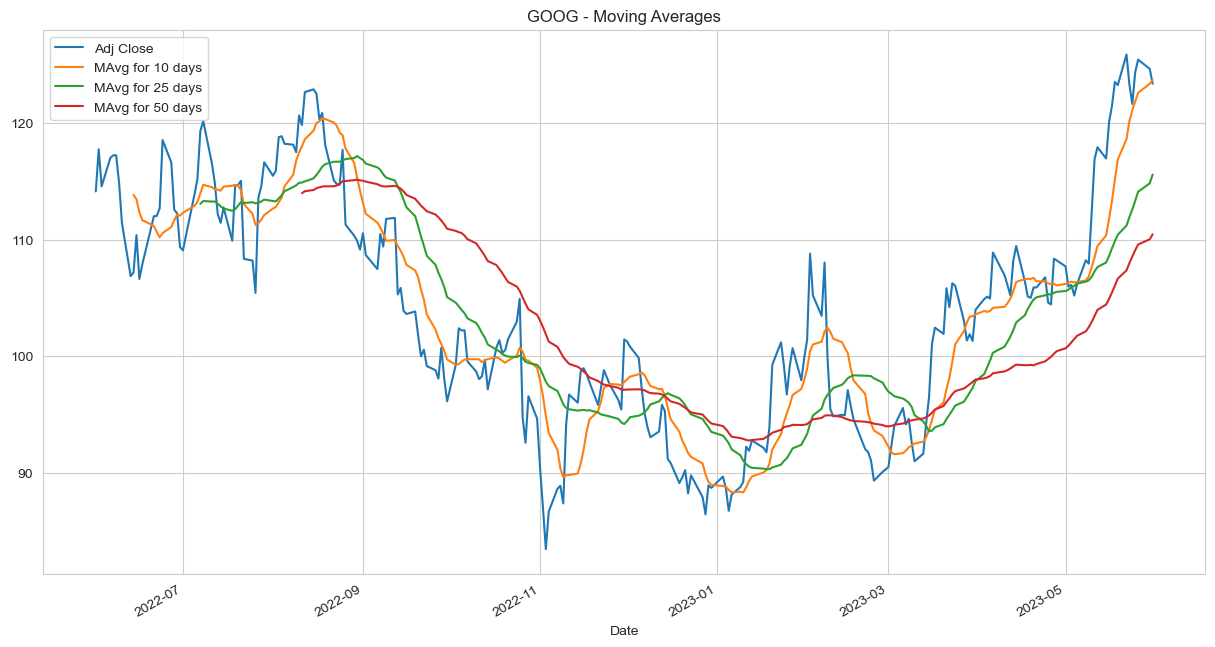

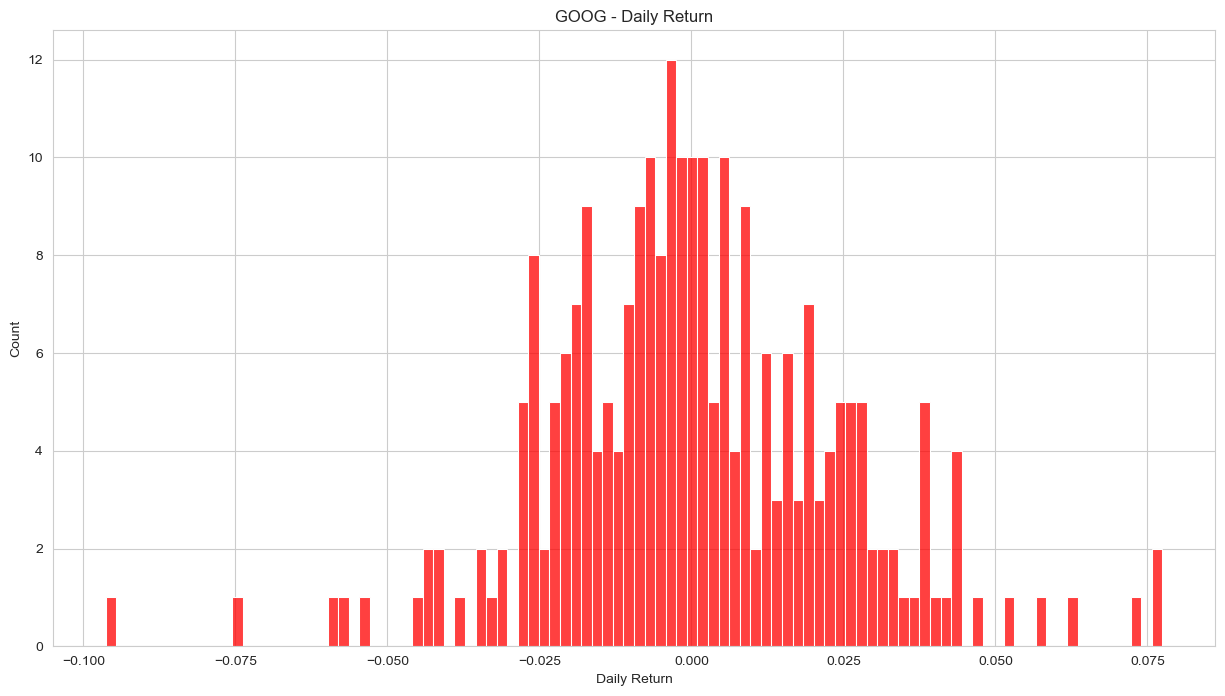

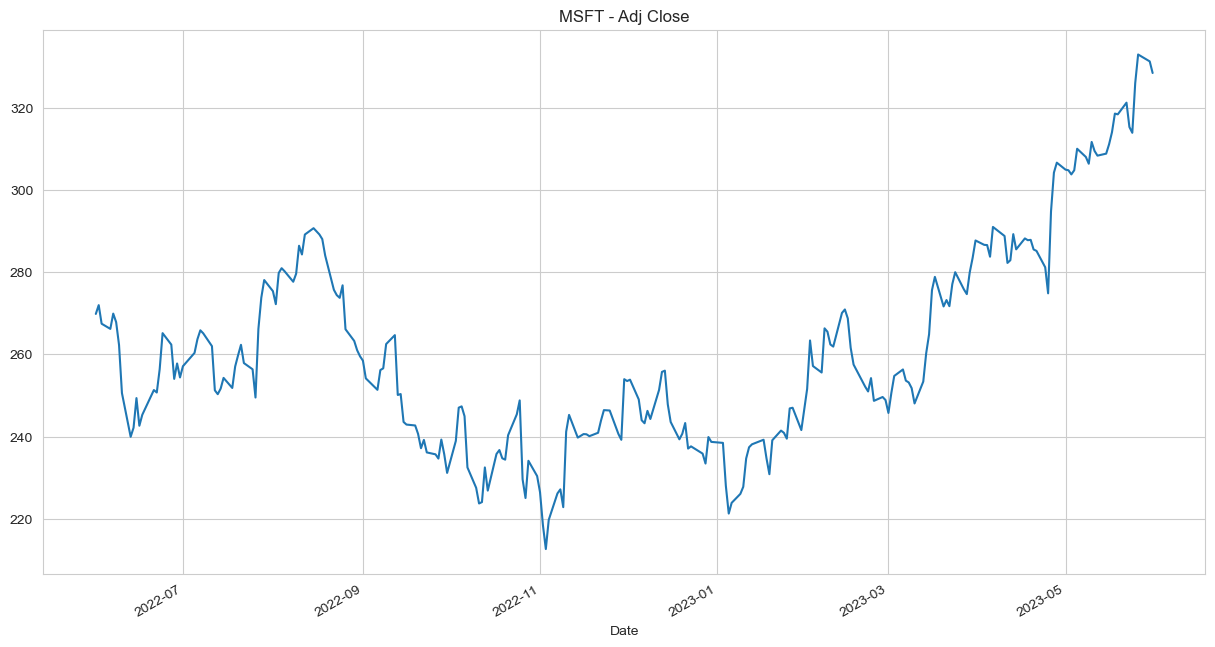

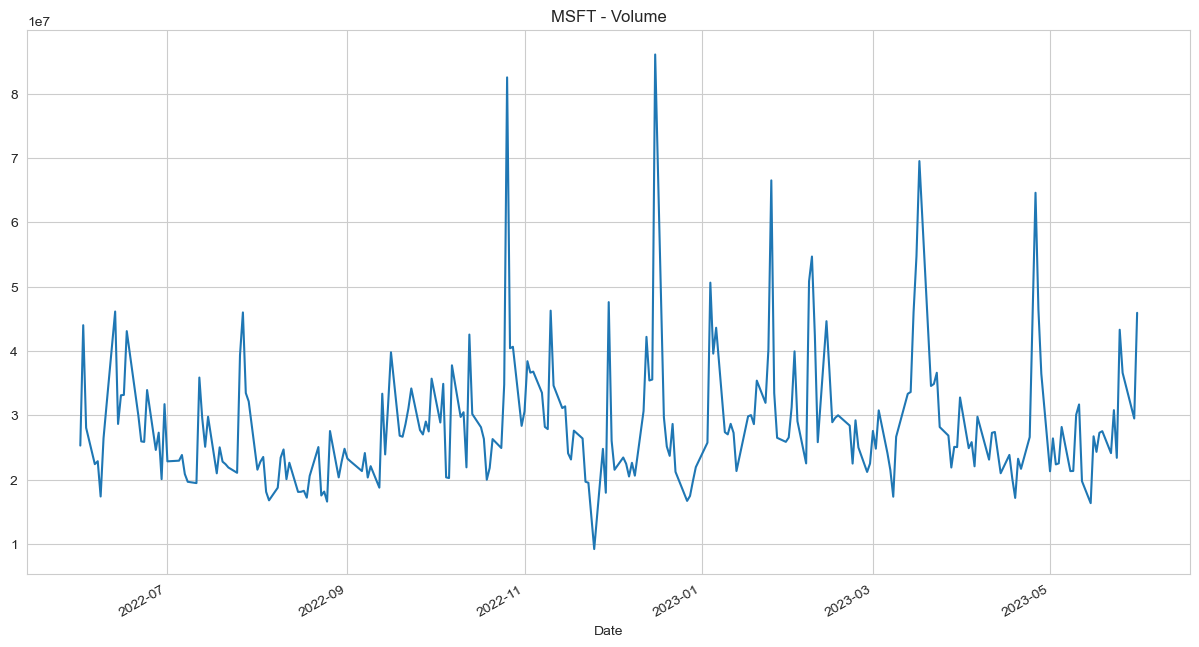

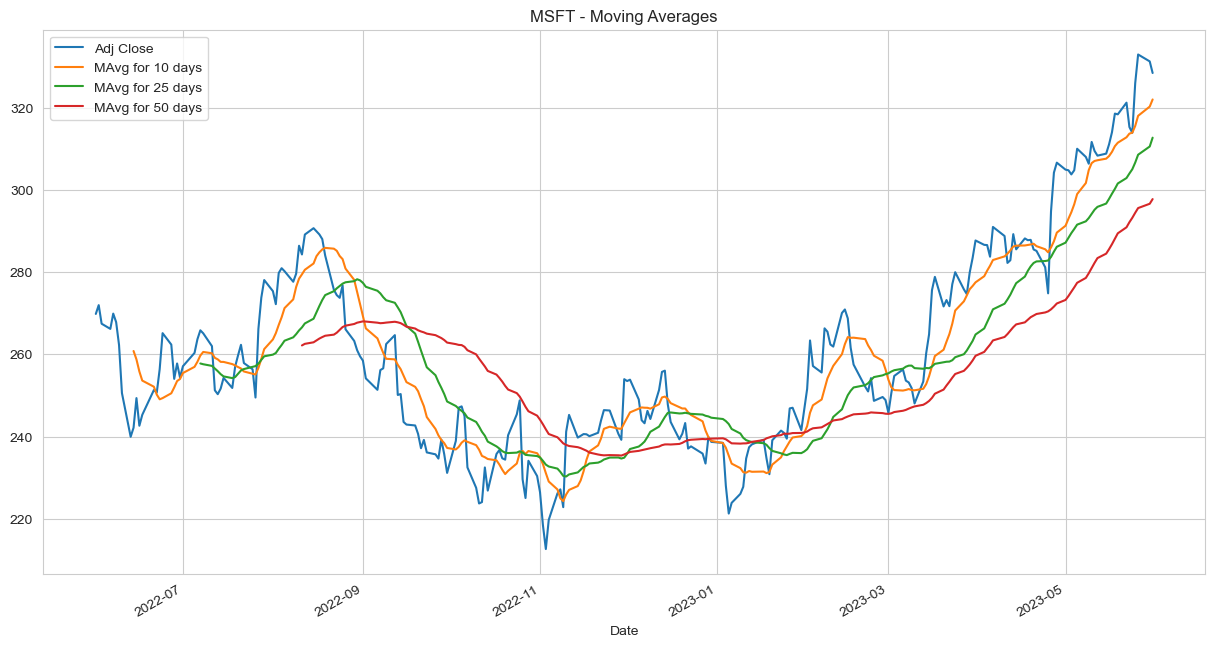

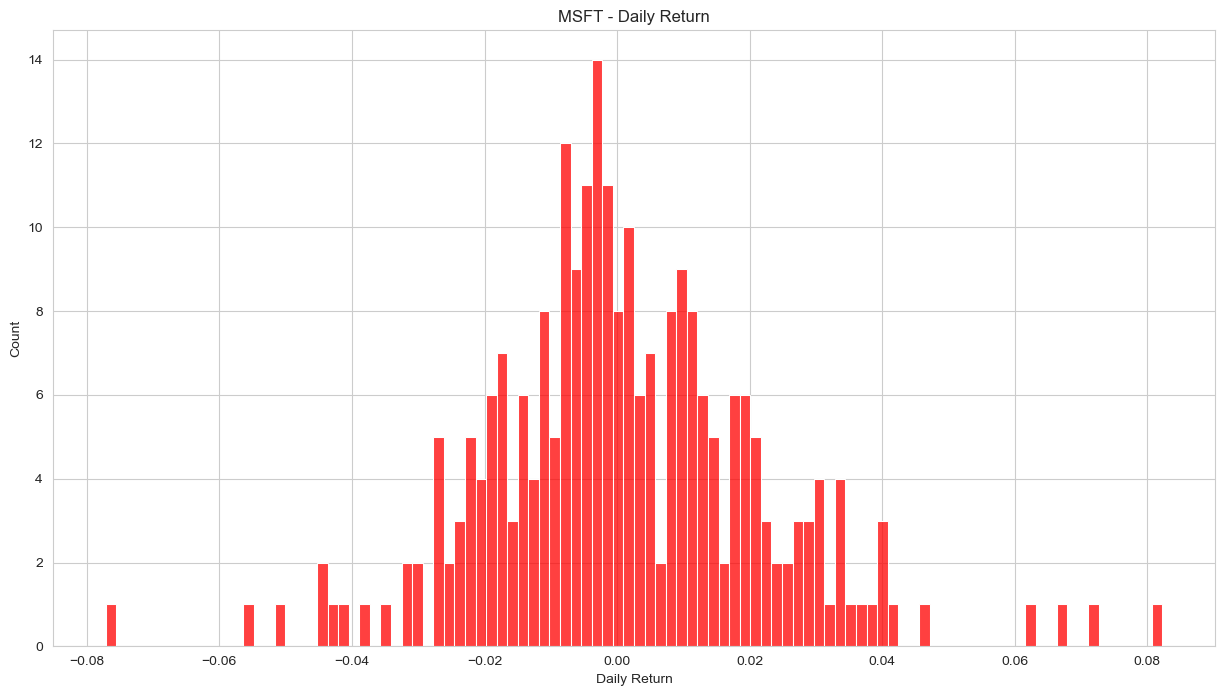

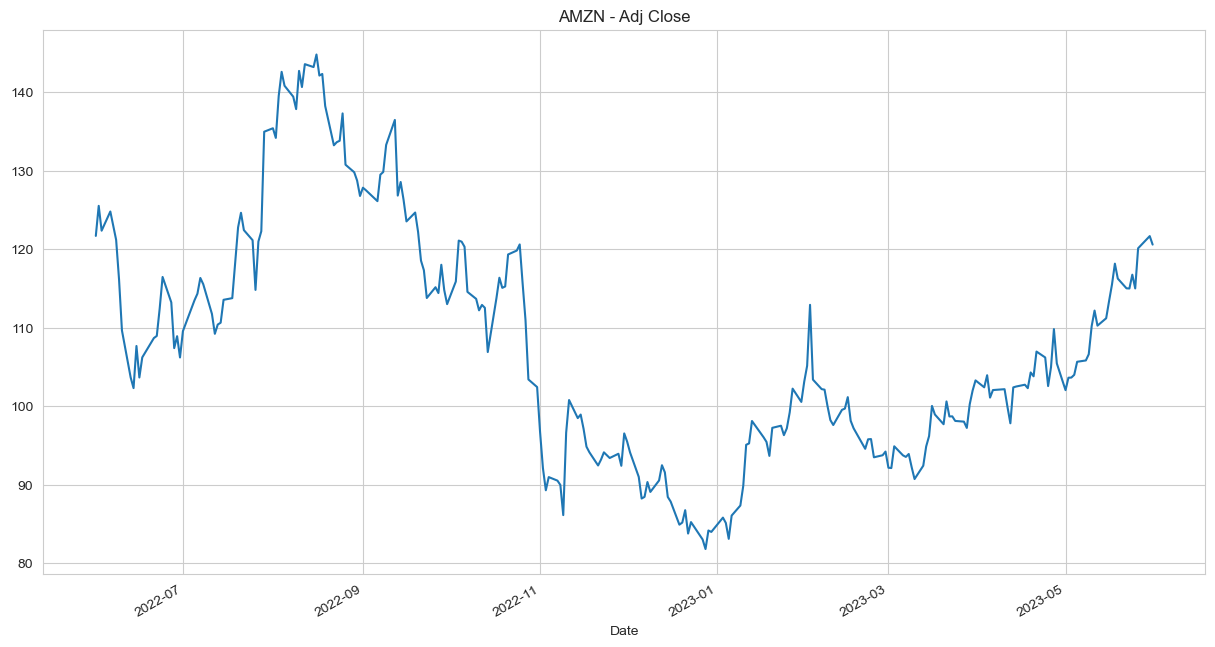

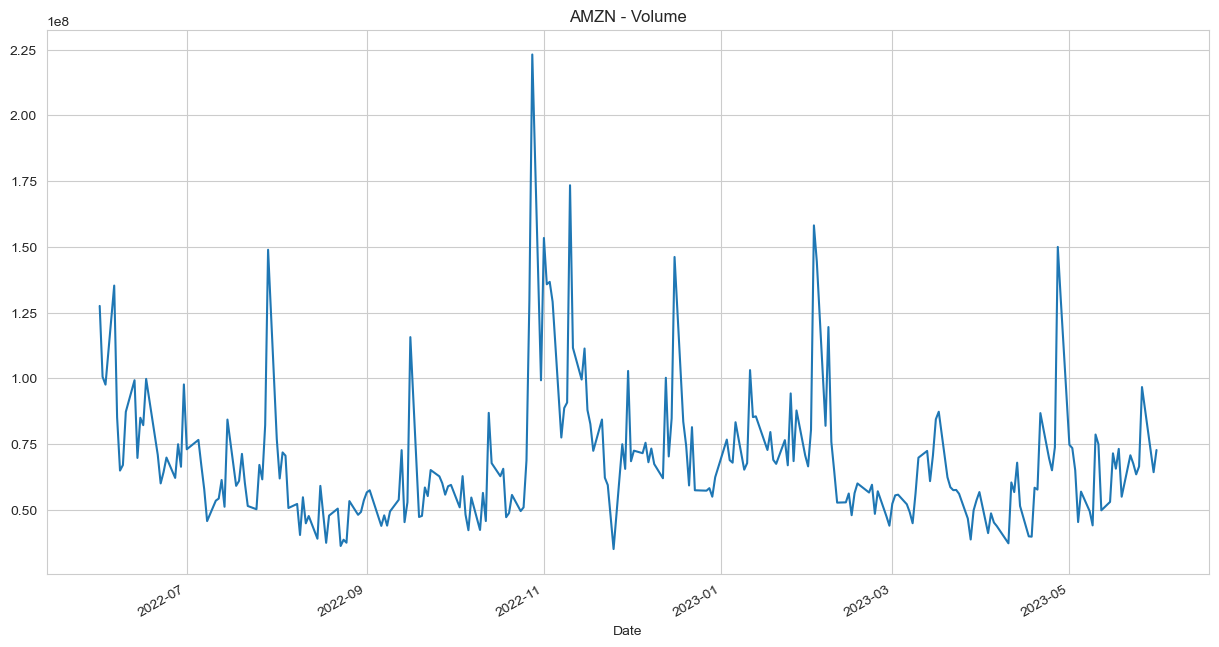

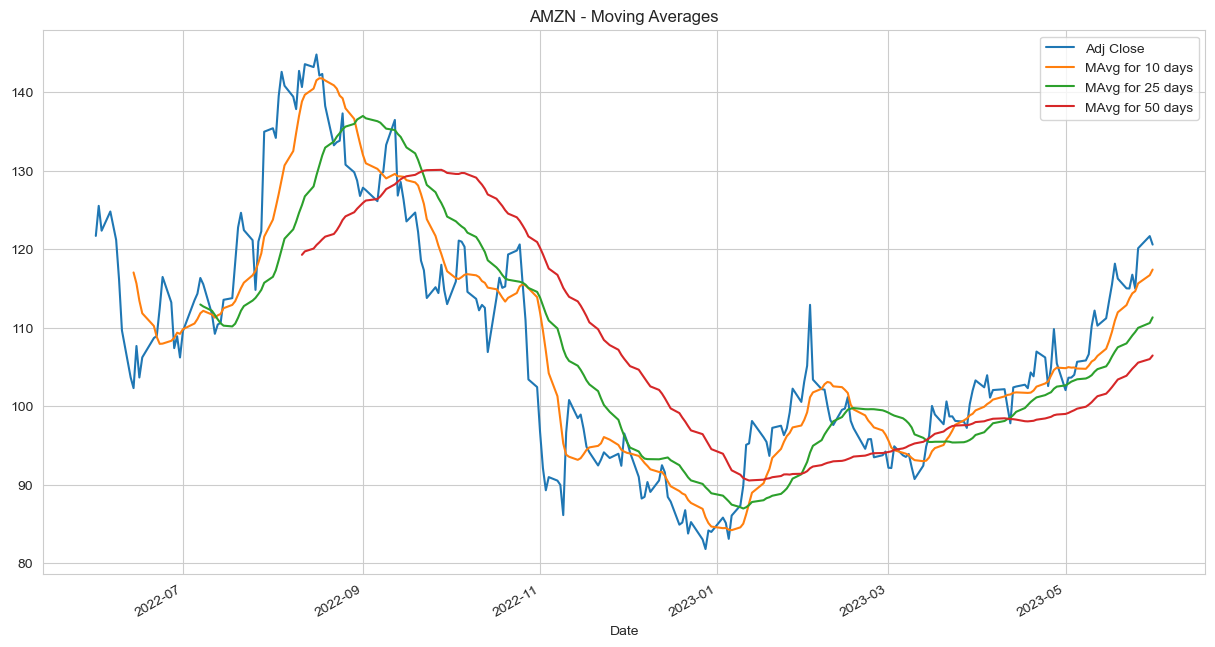

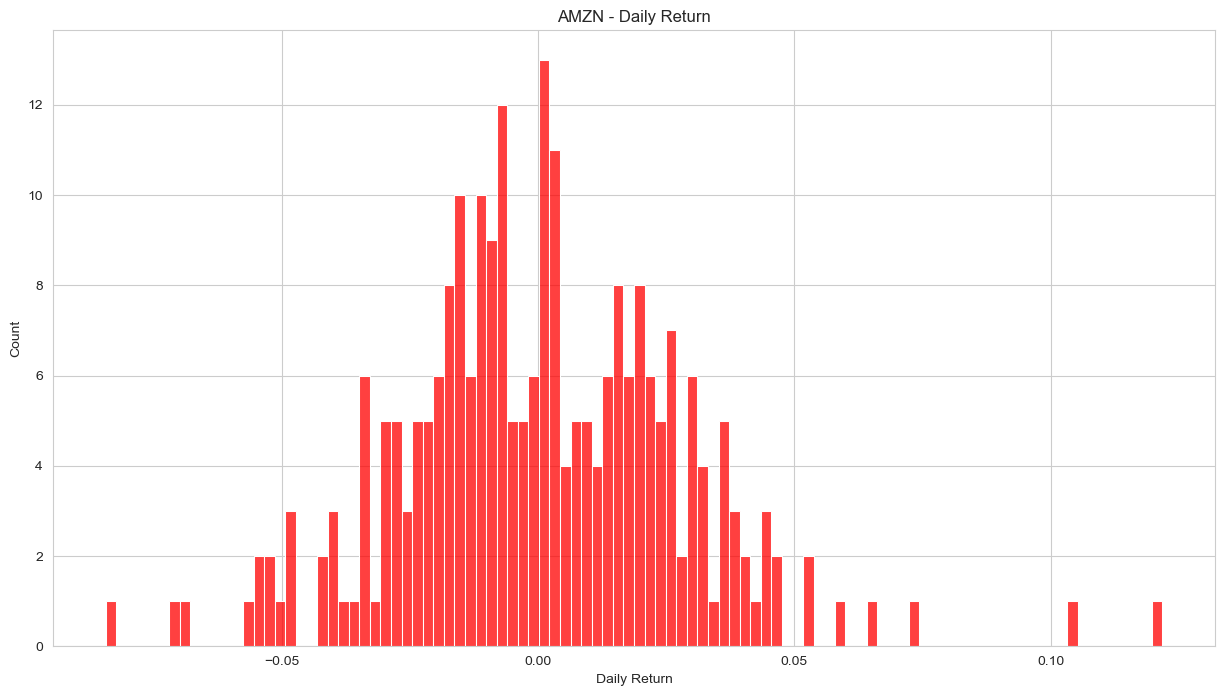

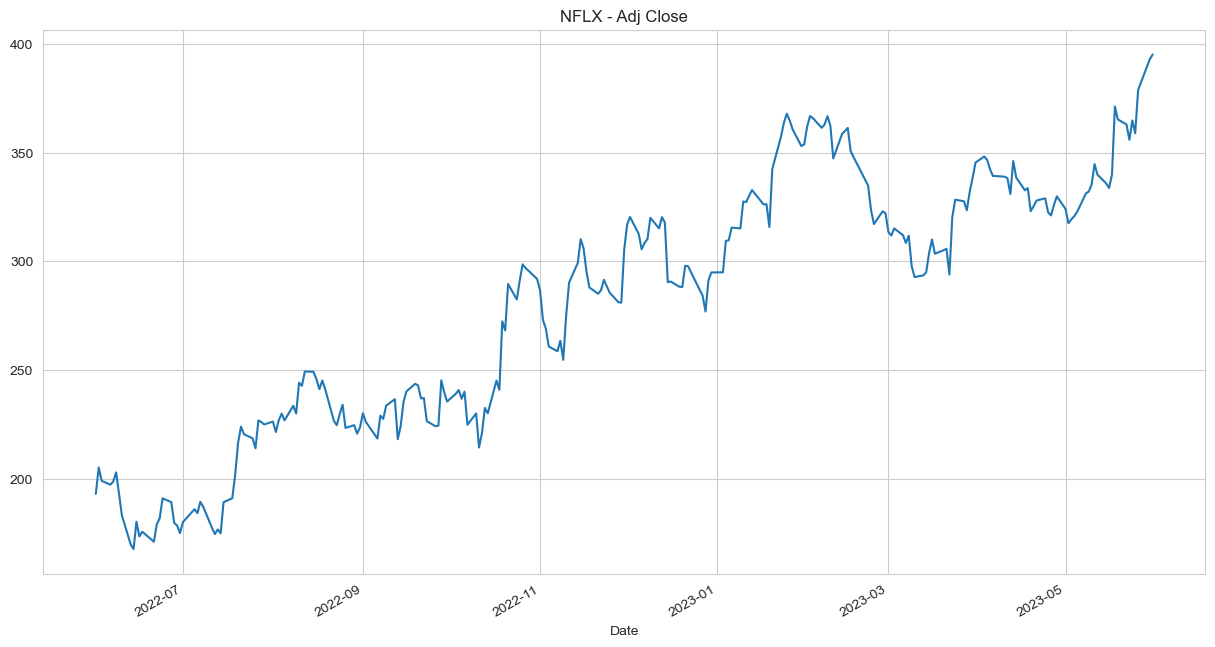

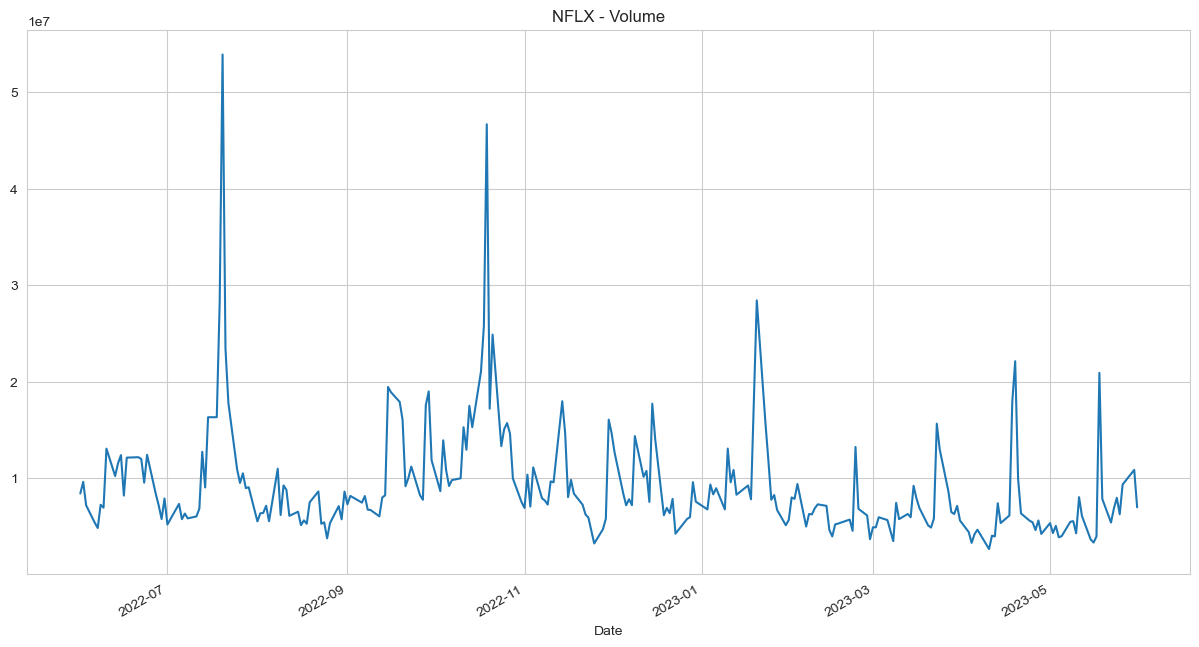

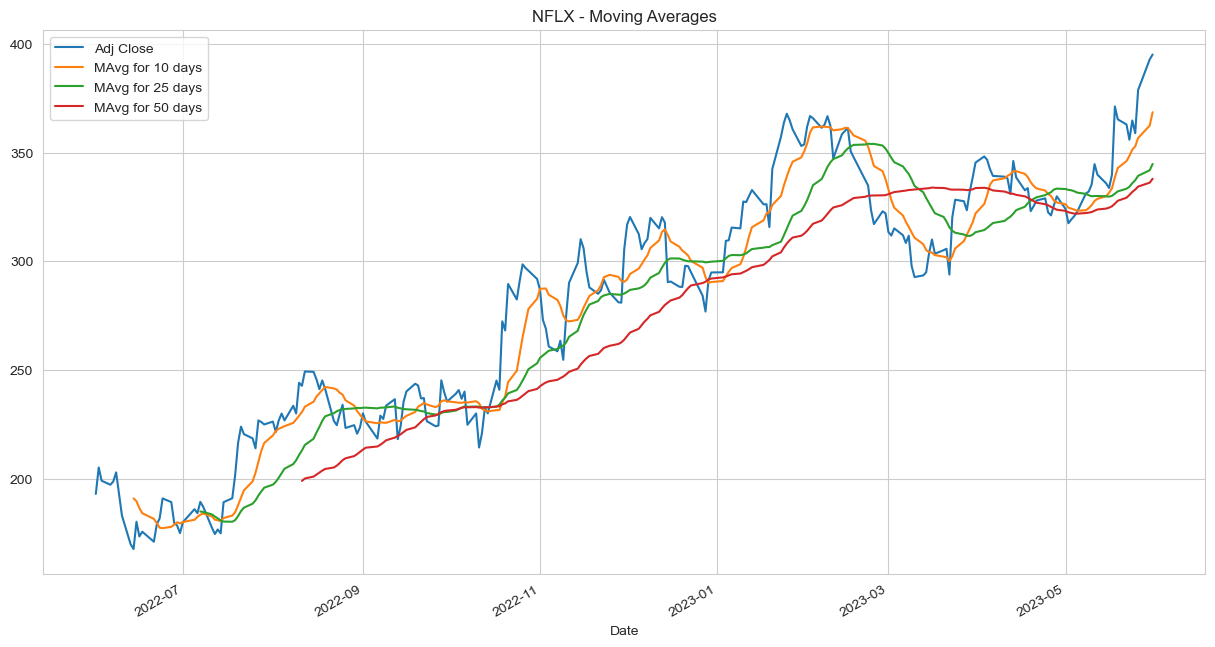

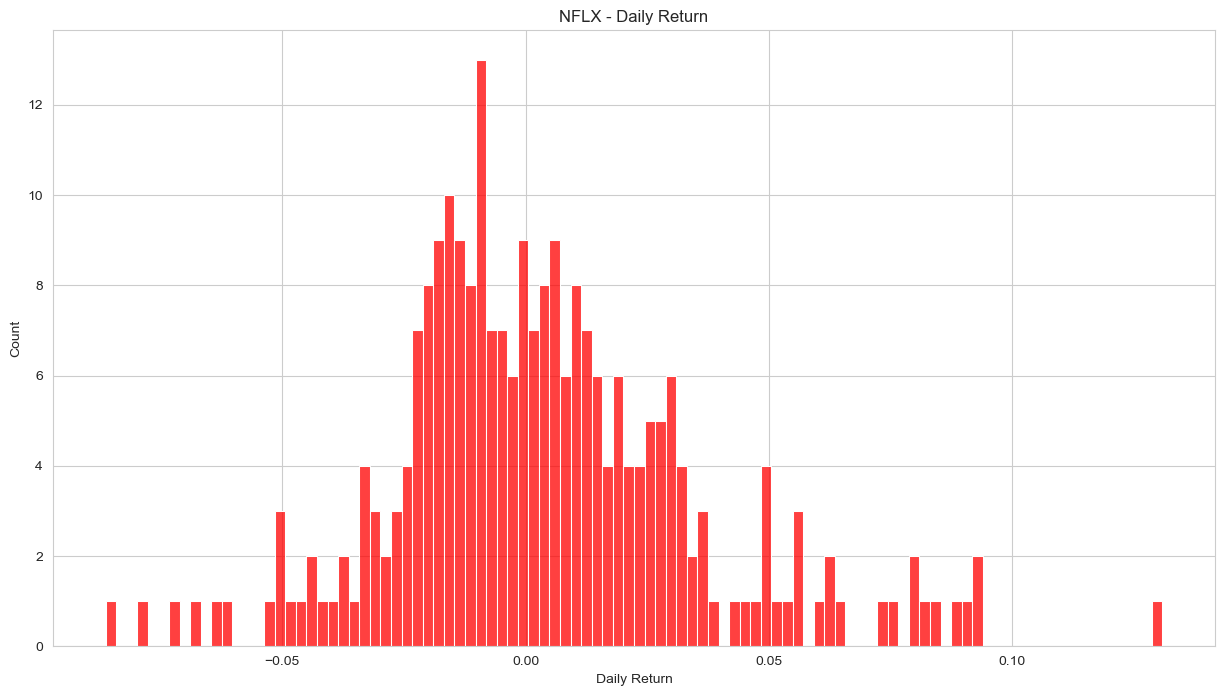

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of averages
averages = [10,25,50]

# Loop through each stock's dataframe
for ticker, df in ticker_data.items():

    # Plot 'Adj Close'
    plt.figure(figsize=(15,8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    # Plot 'Volume'
    plt.figure(figsize=(15,8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    # Compute moving averages and plot them
    for avg in averages:
        label = f"MAvg for {avg} days"
        df[label] = df['Adj Close'].rolling(window=avg, center=False).mean()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15,8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    # Compute daily return
    df['Daily Return'] = df['Adj Close'].pct_change()

    # Plot 'Daily Return'
    plt.figure(figsize=(15,8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

In [130]:
rets_compr = pd.DataFrame()

for ticker in ticker_data:
    rets_compr[ticker] = ticker_data[ticker]['Adj Close'].pct_change()

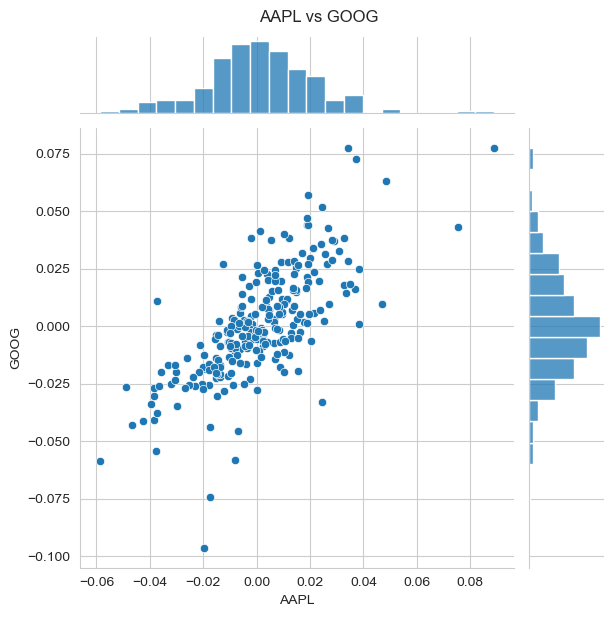

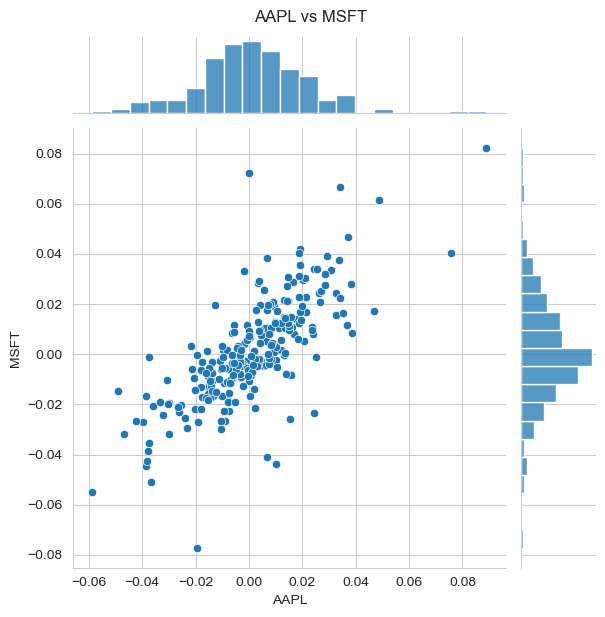

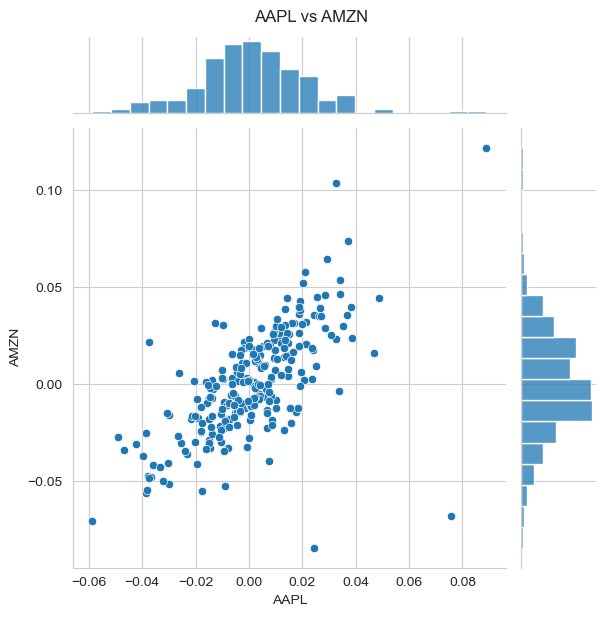

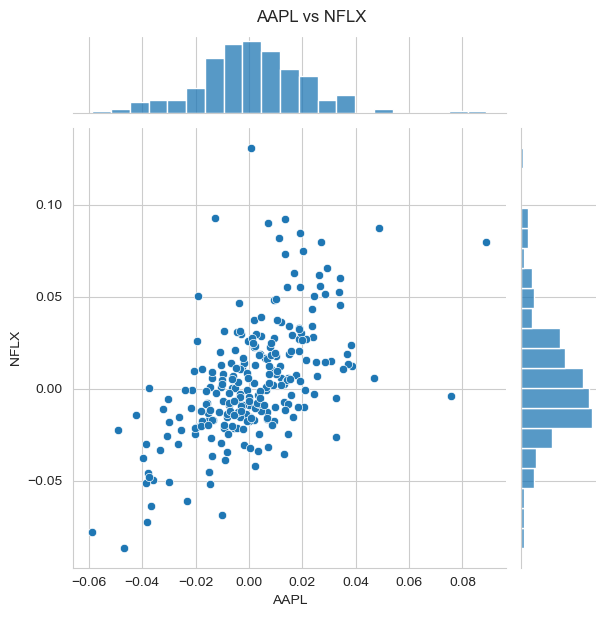

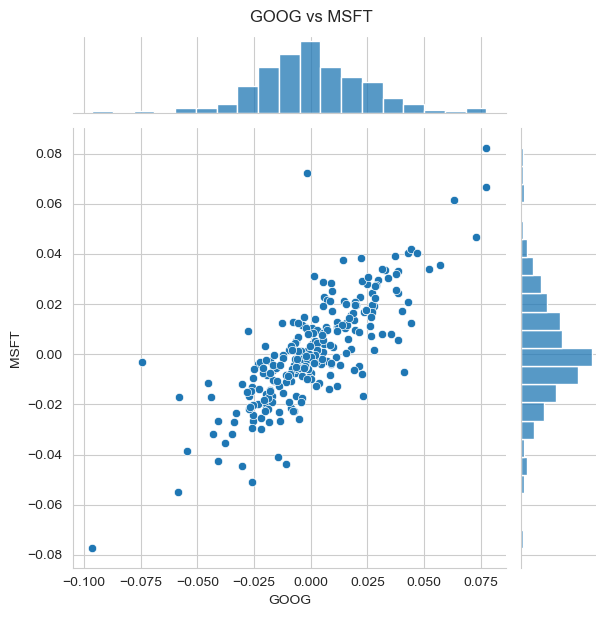

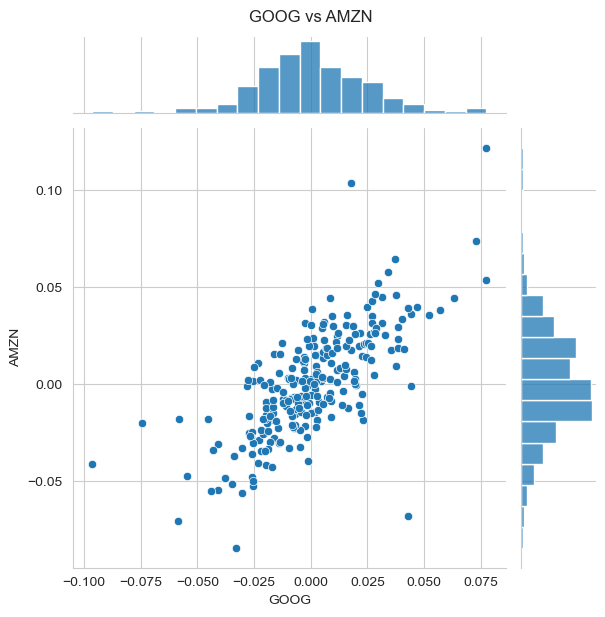

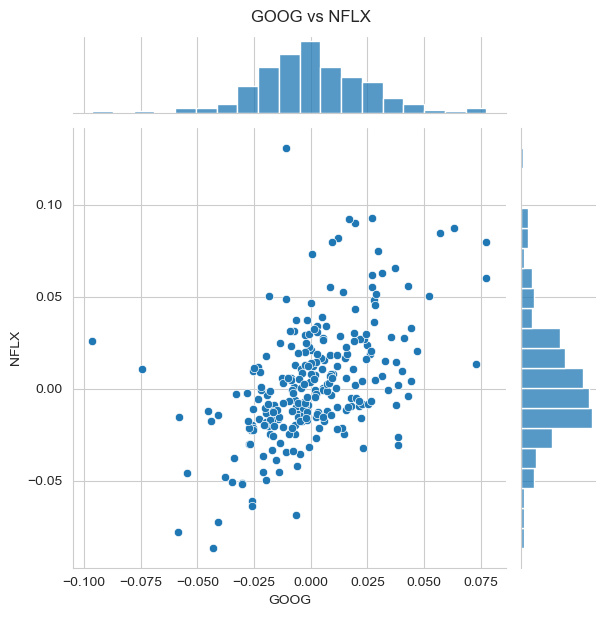

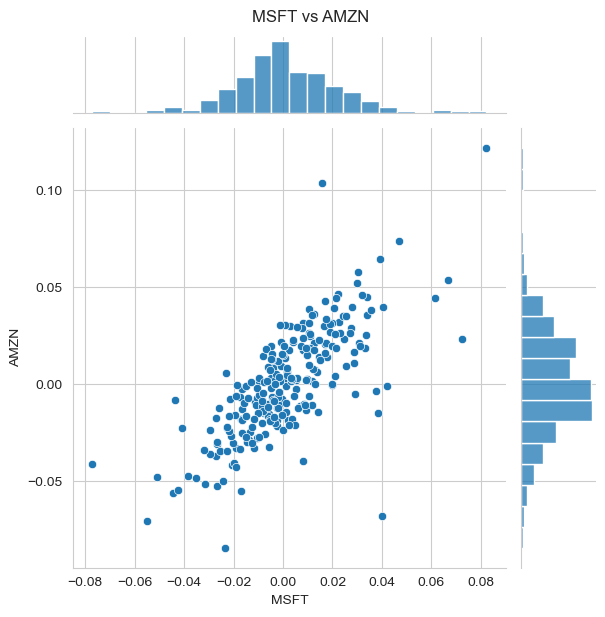

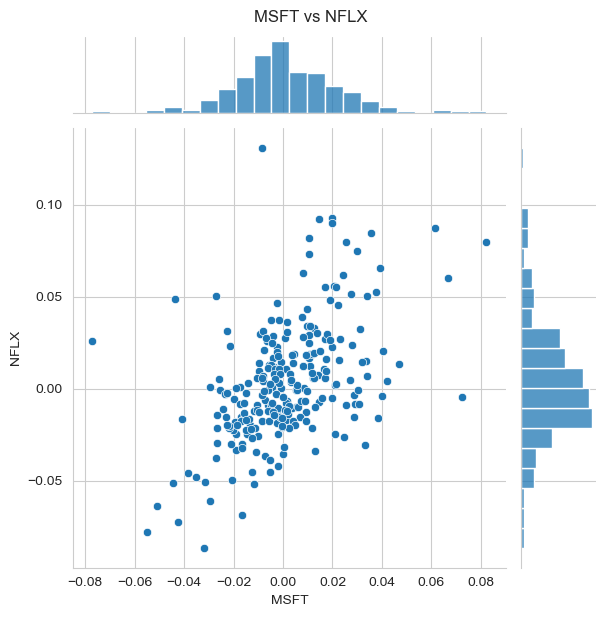

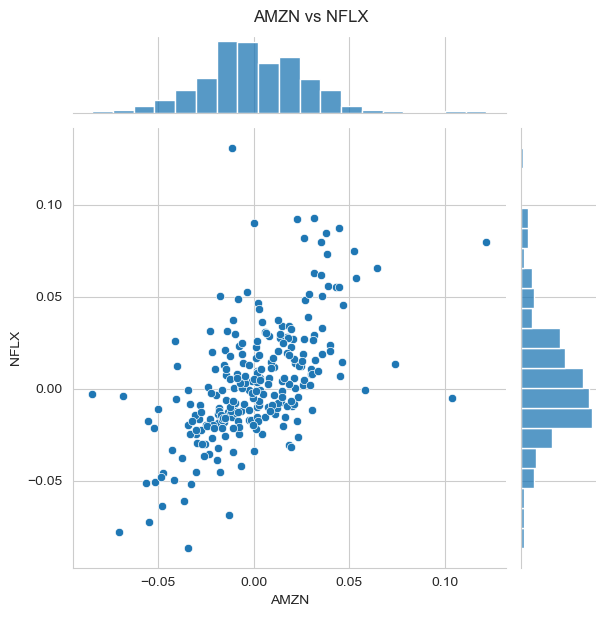

In [131]:
# Assuming rets_compr is the dataframe where you stored the daily returns
for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        sns.jointplot(x=tickers[i], y=tickers[j], data=rets_compr, kind='scatter')
        plt.suptitle(f'{tickers[i]} vs {tickers[j]}', y=1.02)
        plt.show()

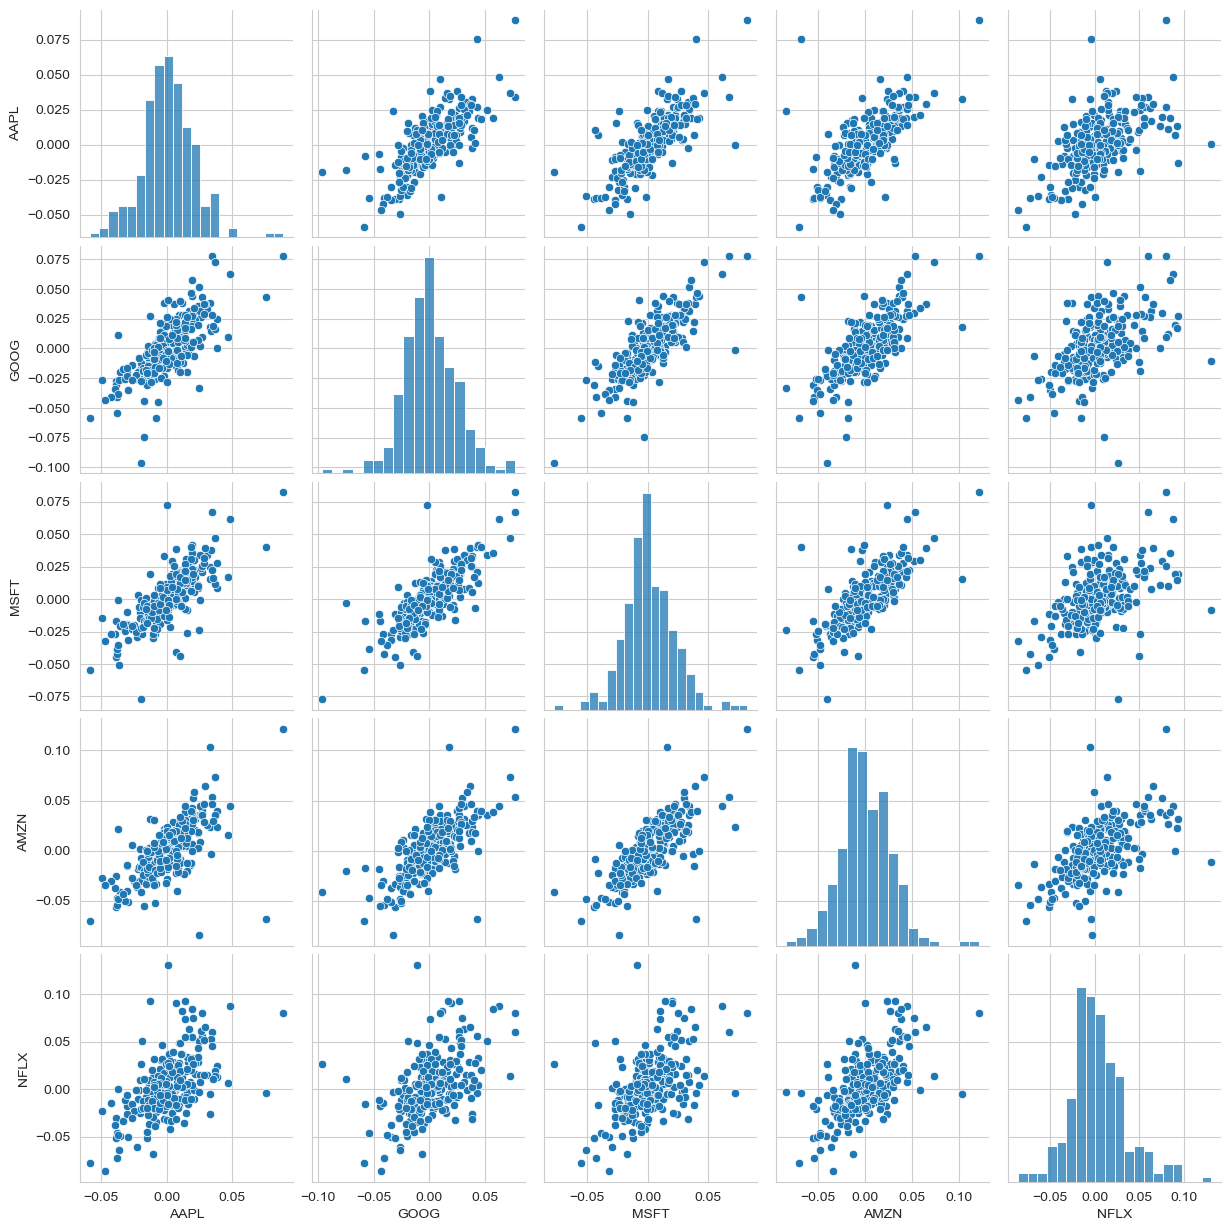

In [132]:
sns.pairplot(rets_compr.dropna())

          AAPL      GOOG      MSFT      AMZN      NFLX
AAPL  1.000000  0.729002  0.750975  0.669613  0.563385
GOOG  0.729002  1.000000  0.797451  0.723329  0.509753
MSFT  0.750975  0.797451  1.000000  0.735054  0.495282
AMZN  0.669613  0.723329  0.735054  1.000000  0.583521
NFLX  0.563385  0.509753  0.495282  0.583521  1.000000


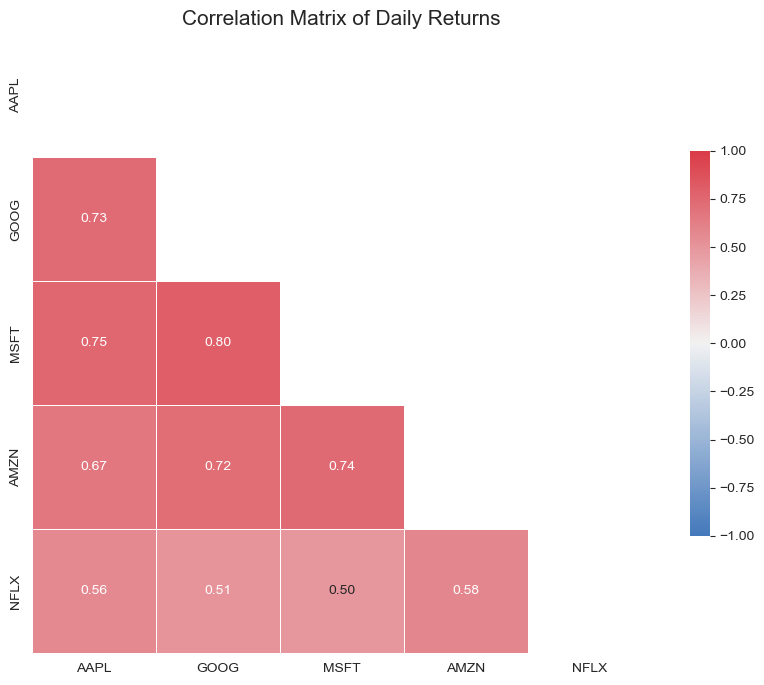

In [133]:
# Assuming rets_compr is the dataframe where you stored the daily returns
correlation_matrix = rets_compr.corr()
print(correlation_matrix)

# Create a mask to only show the lower triangle of the matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Initialize matplotlib figure
fig, ax = plt.subplots(figsize=(10, 10))

# Create a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.title('Correlation Matrix of Daily Returns', fontsize=15)
plt.show()


## Random Forest to Predict Adj Close 

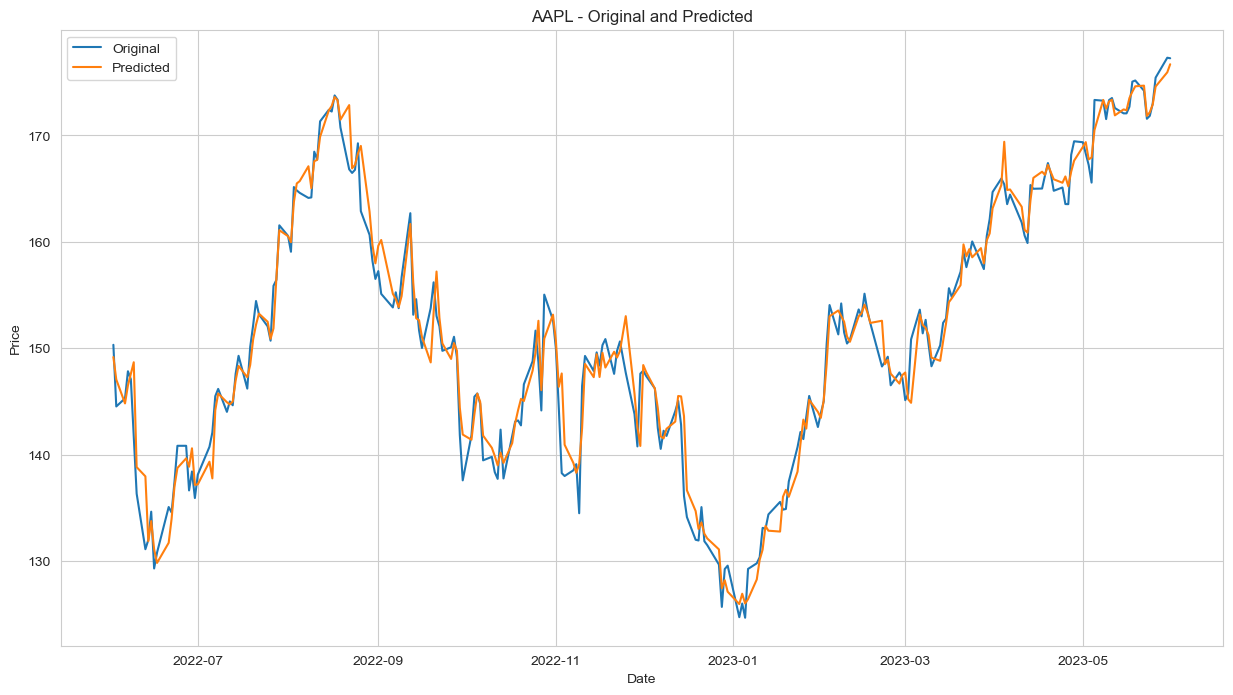

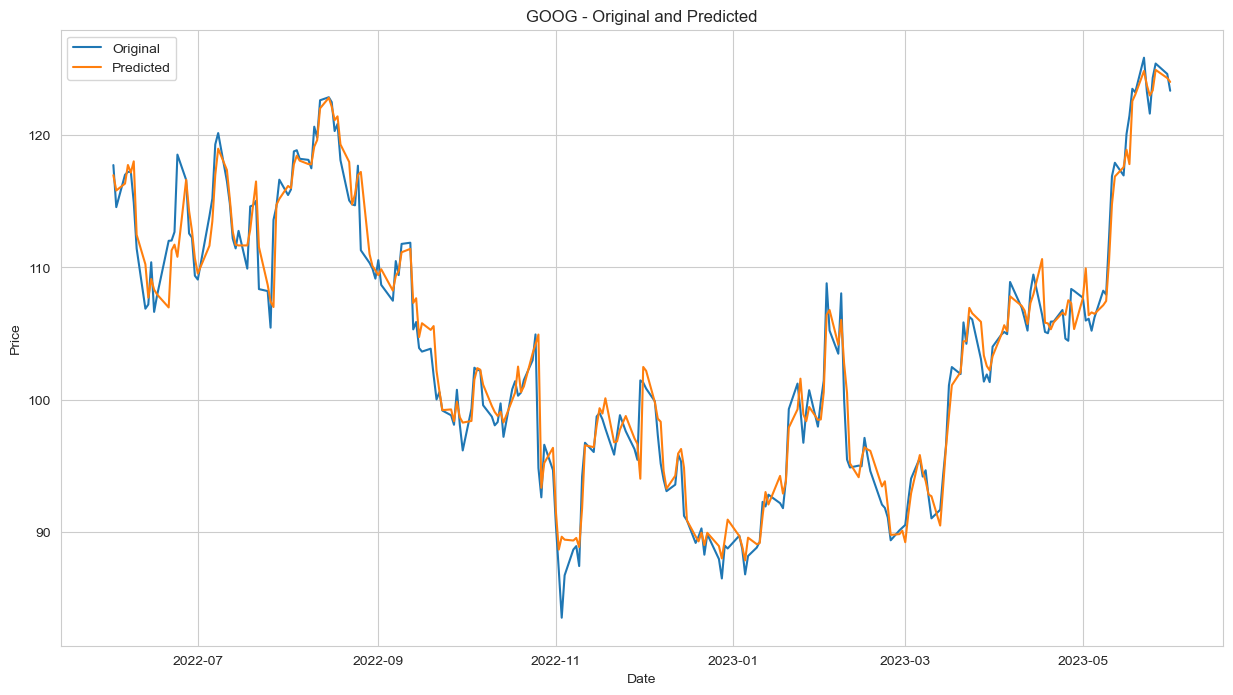

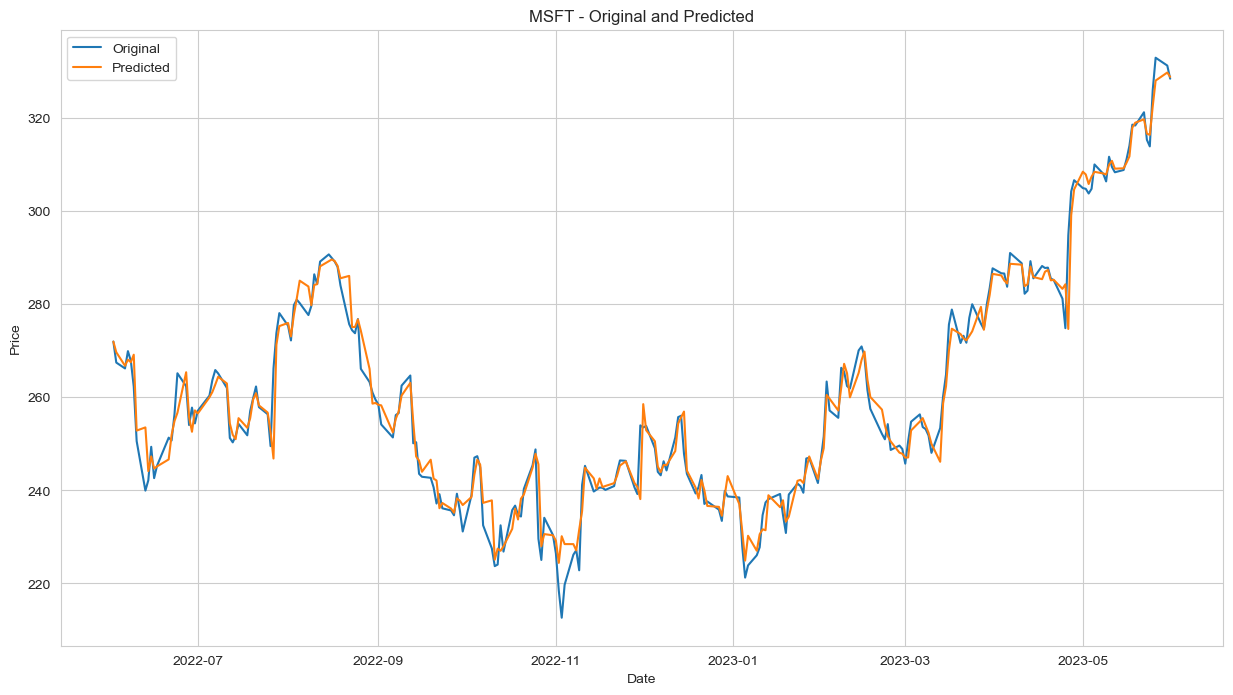

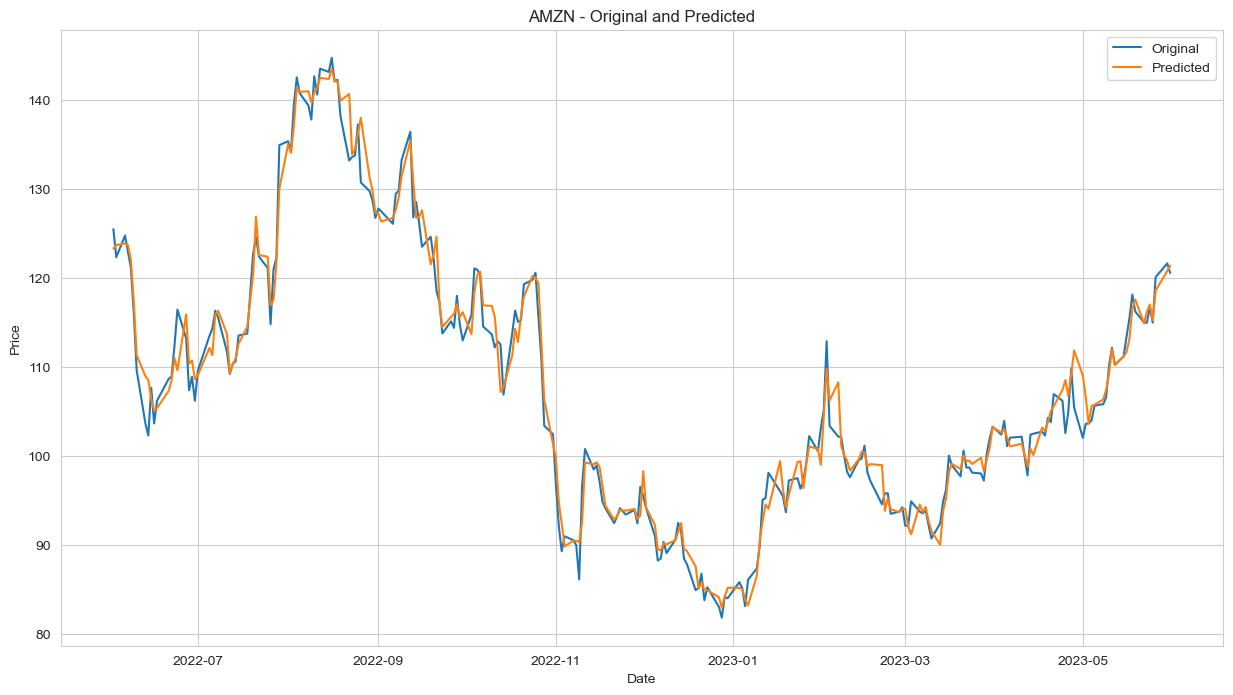

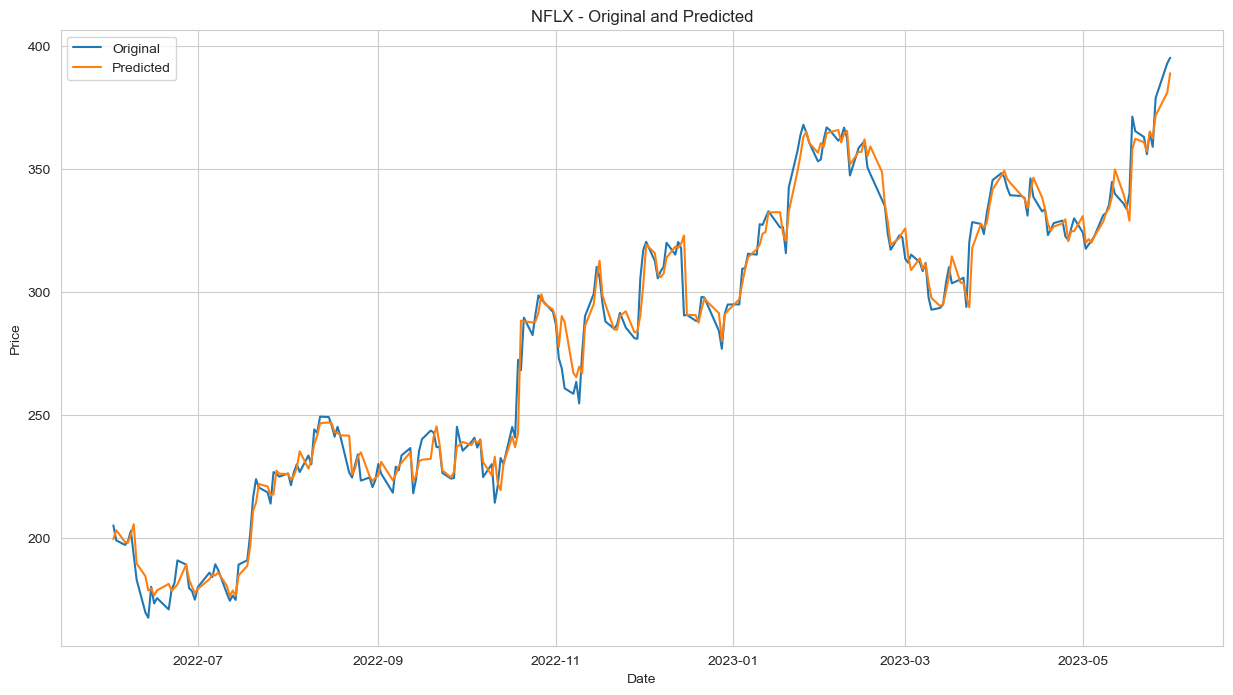

AAPL Predictions with RandomForest: Mean absolute error: 2.51
GOOG Predictions with RandomForest: Mean absolute error: 2.15
MSFT Predictions with RandomForest: Mean absolute error: 4.74
AMZN Predictions with RandomForest: Mean absolute error: 2.57
NFLX Predictions with RandomForest: Mean absolute error: 8.33


In [134]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

MAE_results = {}

# For each stock
for ticker, df in ticker_data.items():
    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    randomForestModel = RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2, min_samples_leaf=1, max_depth=10, bootstrap=True)
    randomForestModel.fit(x_train, y_train)

    # Predict the stock prices
    predict = randomForestModel.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['RandomForest'] = mean_absolute_error

    # Predict all y values from the original x values
    predict_all = randomForestModel.predict(scaler.transform(x))
    # Plot original y values and predicted y values
    plt.figure(figsize=(15, 8))
    plt.plot(df.index[1:], y, label='Original')
    plt.plot(df.index[1:], predict_all, label='Predicted')
    plt.title(f'{ticker} - Original and Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")




## SVM to Predict Adj Close

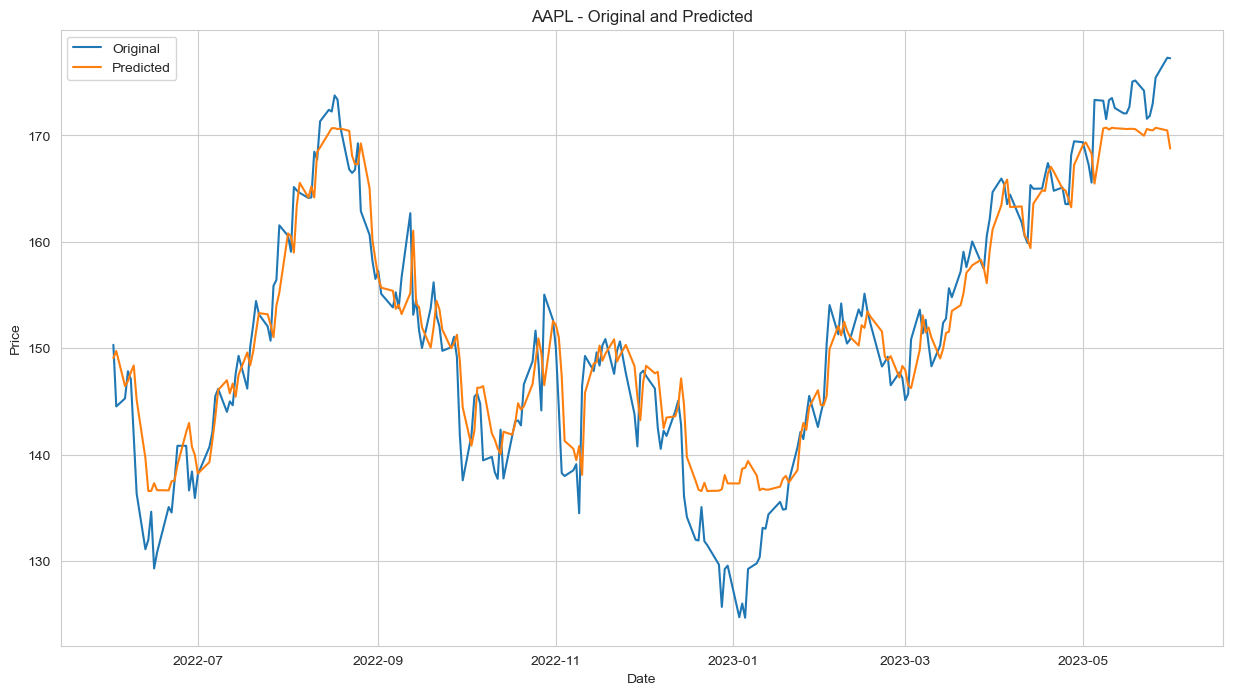

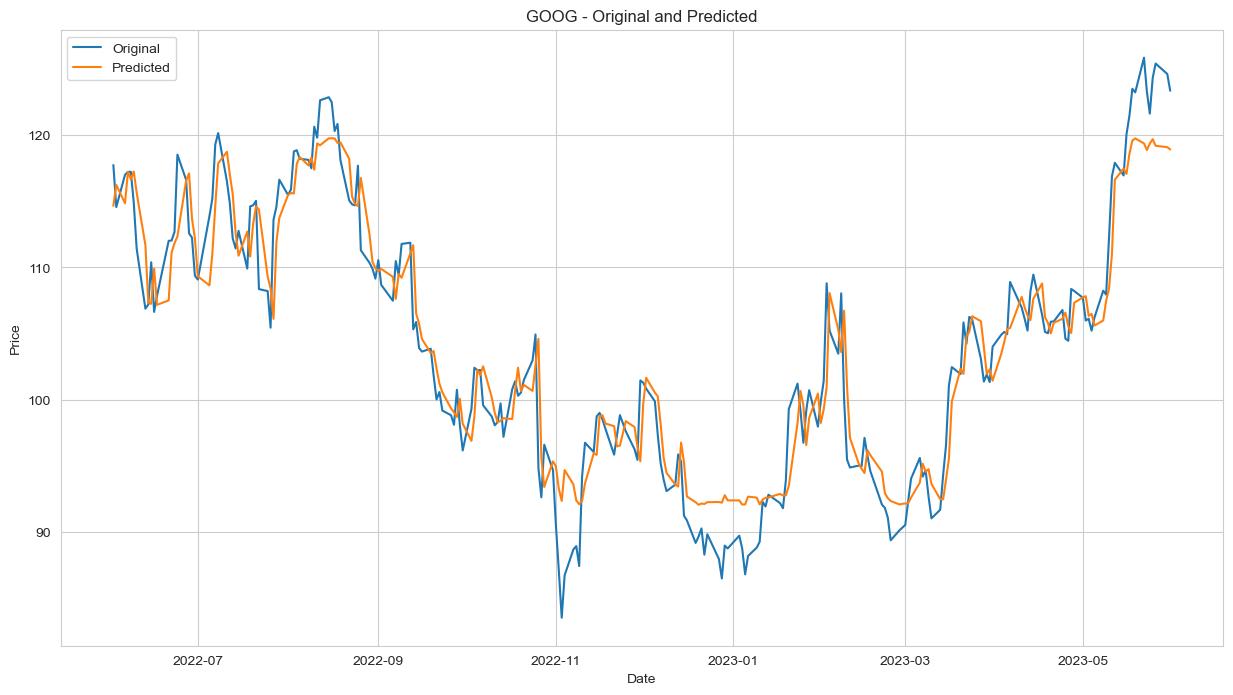

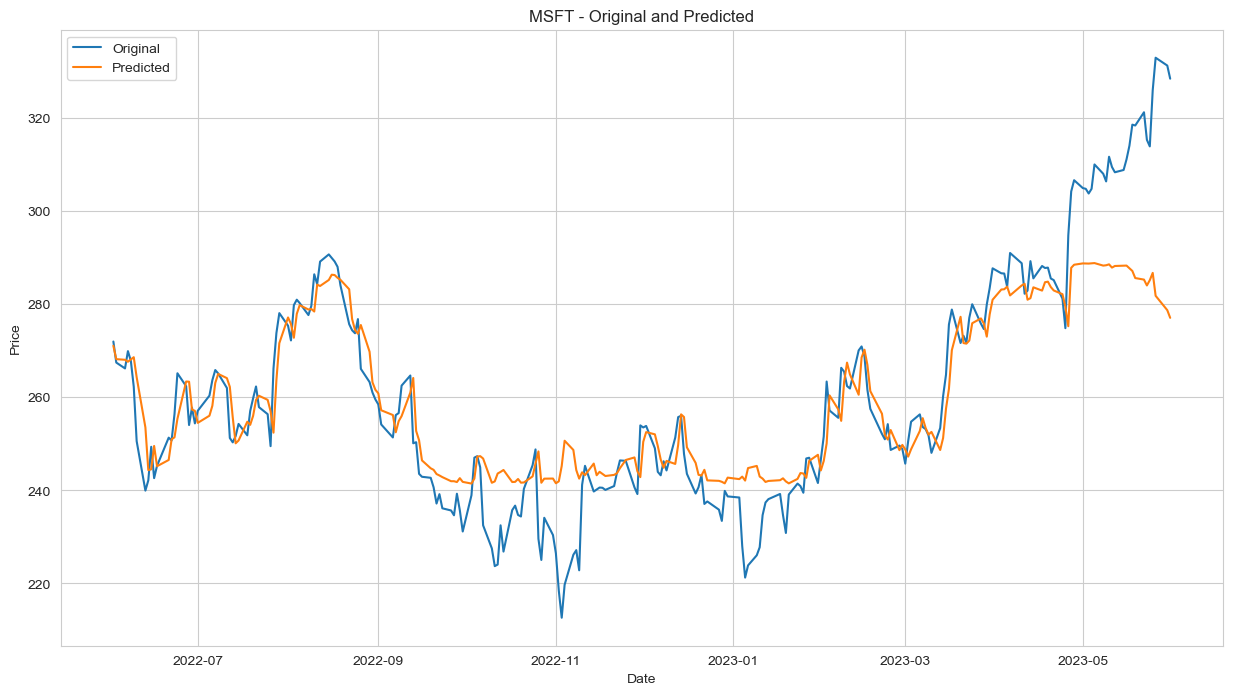

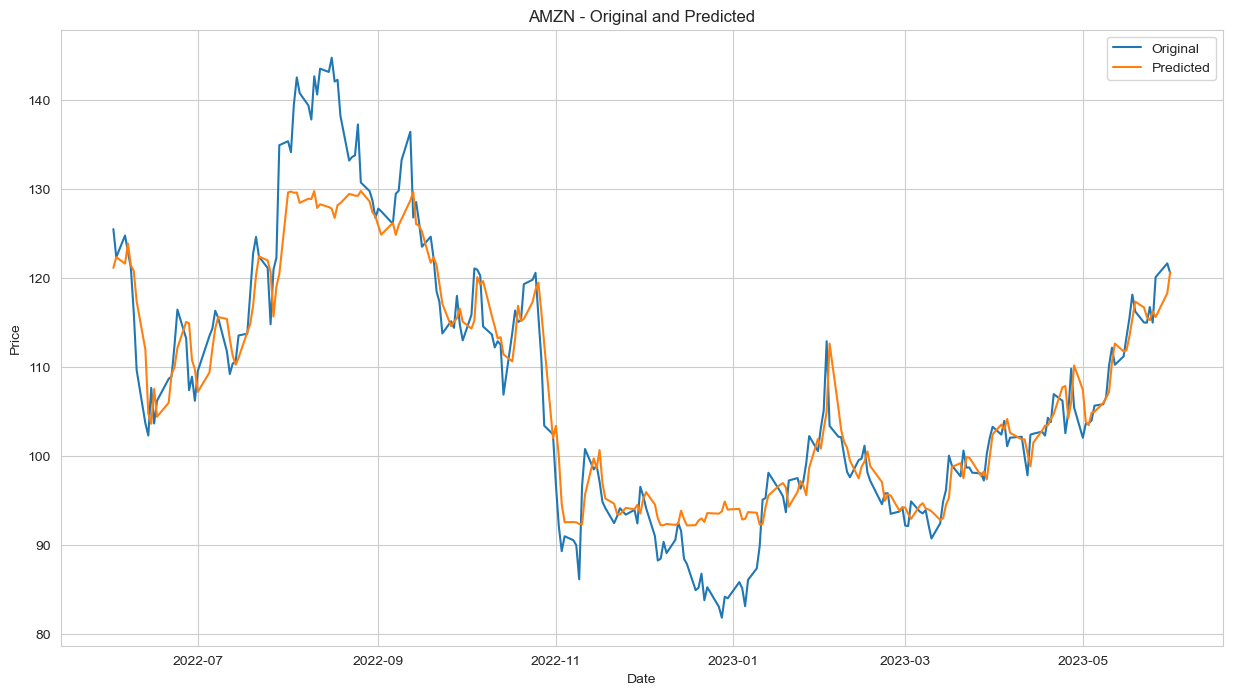

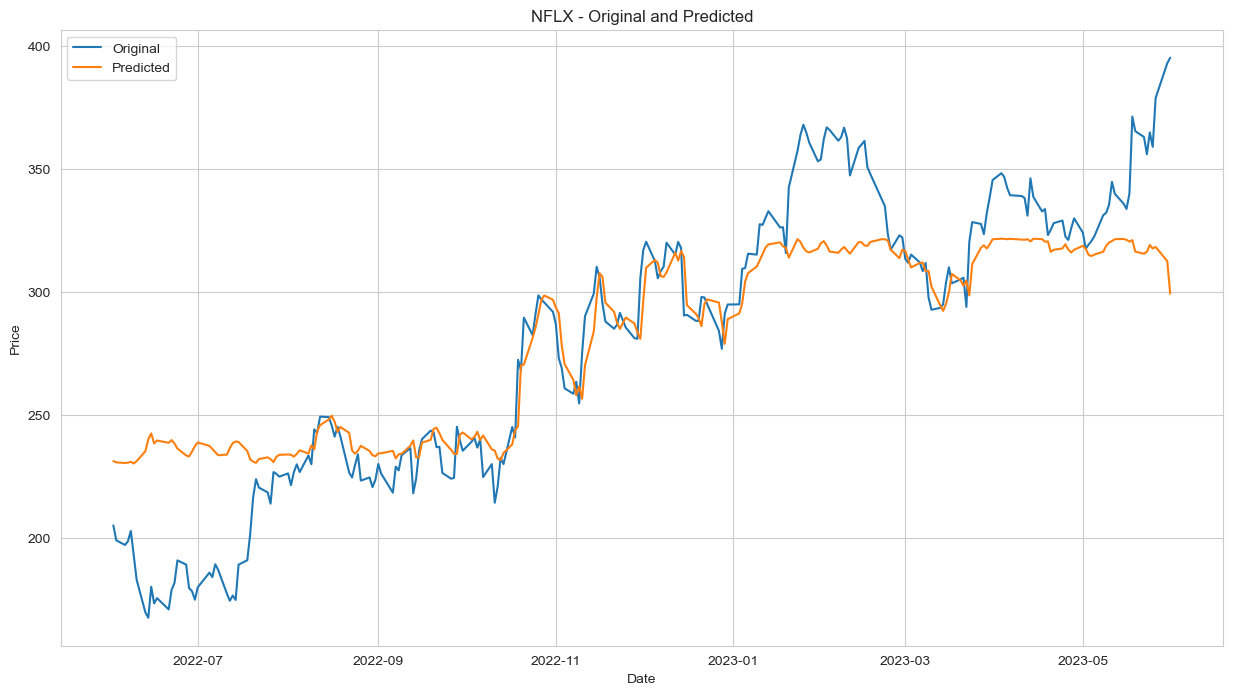

AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
NFLX Predictions with RandomForest: Mean absolute error: 8.33
NFLX Predictions with SVR: Mean absolute error: 17.63


In [135]:
from sklearn.svm import SVR



# For each stock
for ticker, df in ticker_data.items():
    
    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    SVRmodel = SVR(kernel='rbf')
    SVRmodel.fit(x_train, y_train)

    # Predict the stock prices
    predict = SVRmodel.predict(x_test)

    # # Calculate accuracy
    # accuracy = round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)


    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store accuracy into the dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    
    MAE_results[ticker]['SVR'] = mean_absolute_error
        # Predict all y values from the original x values
    predict_all = SVRmodel.predict(scaler.transform(x))
    # Plot original y values and predicted y values
    plt.figure(figsize=(15, 8))
    plt.plot(df.index[1:], y, label='Original')
    plt.plot(df.index[1:], predict_all, label='Predicted')
    plt.title(f'{ticker} - Original and Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


# Print metrics
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


## KNeighborsRegressor to Predict Adj Close

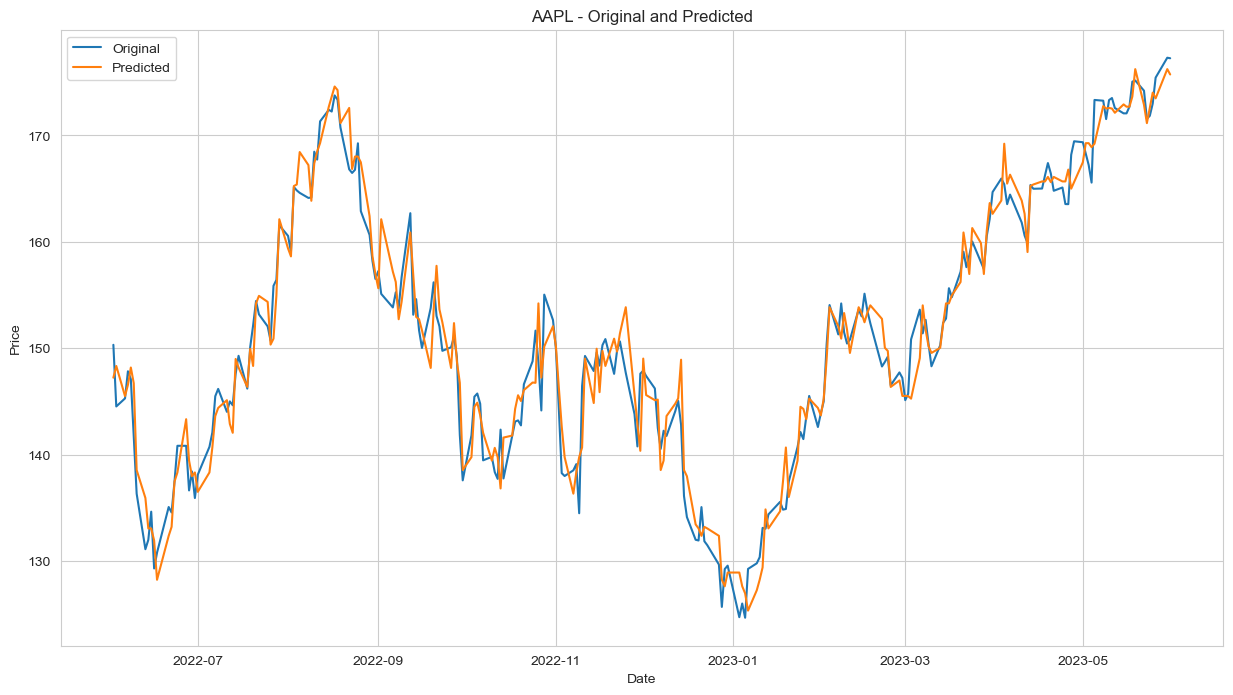

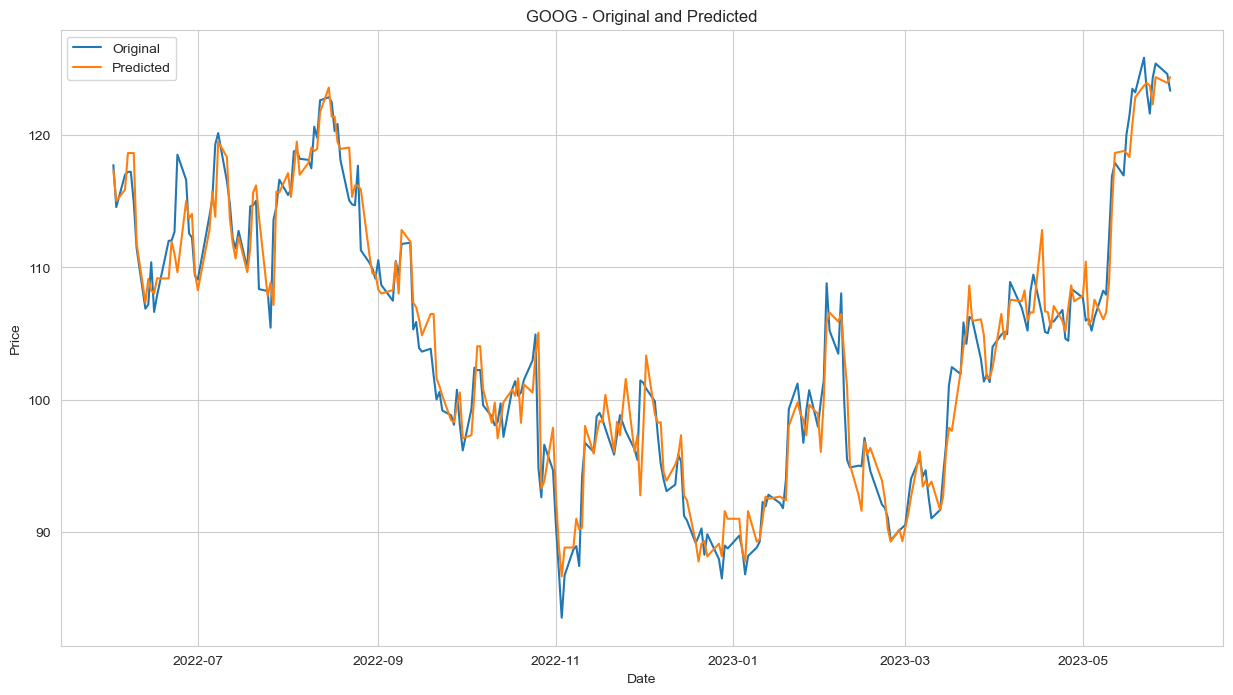

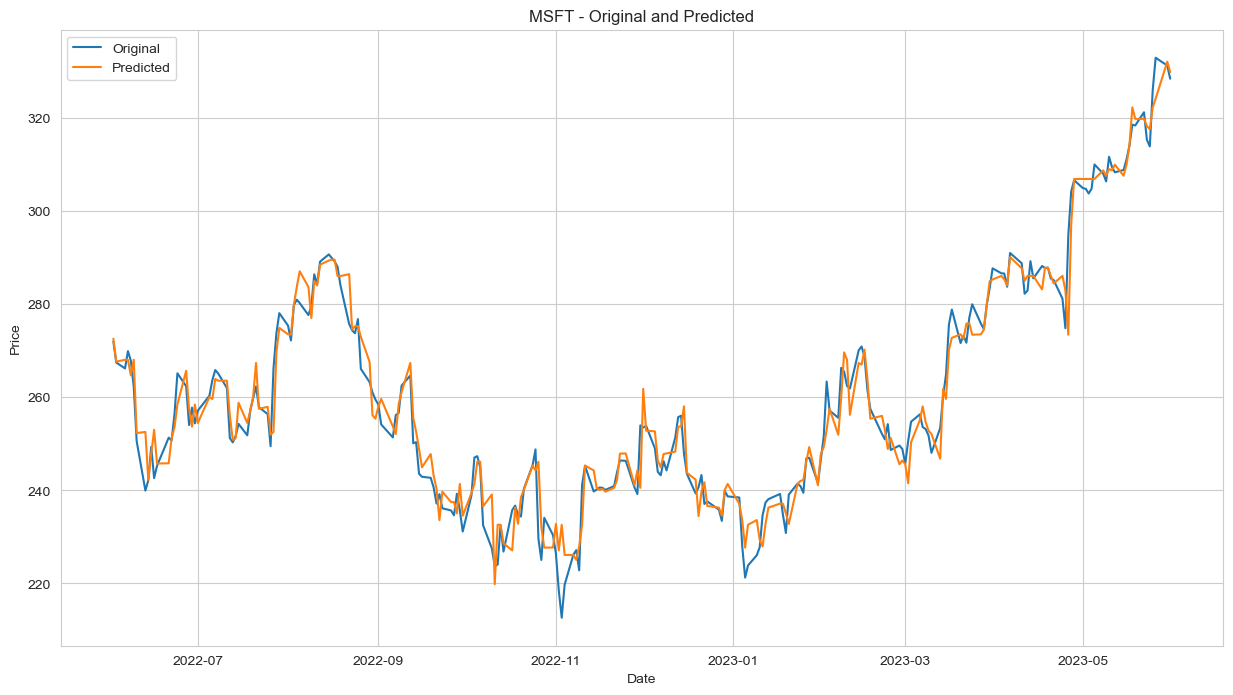

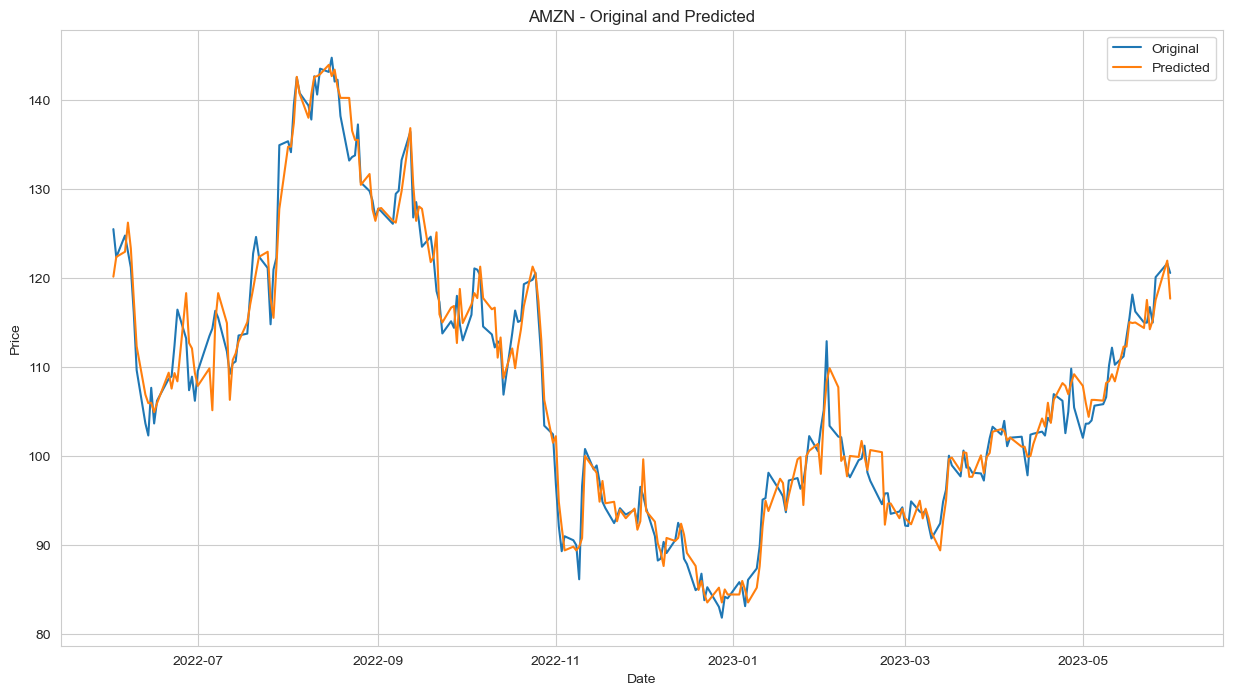

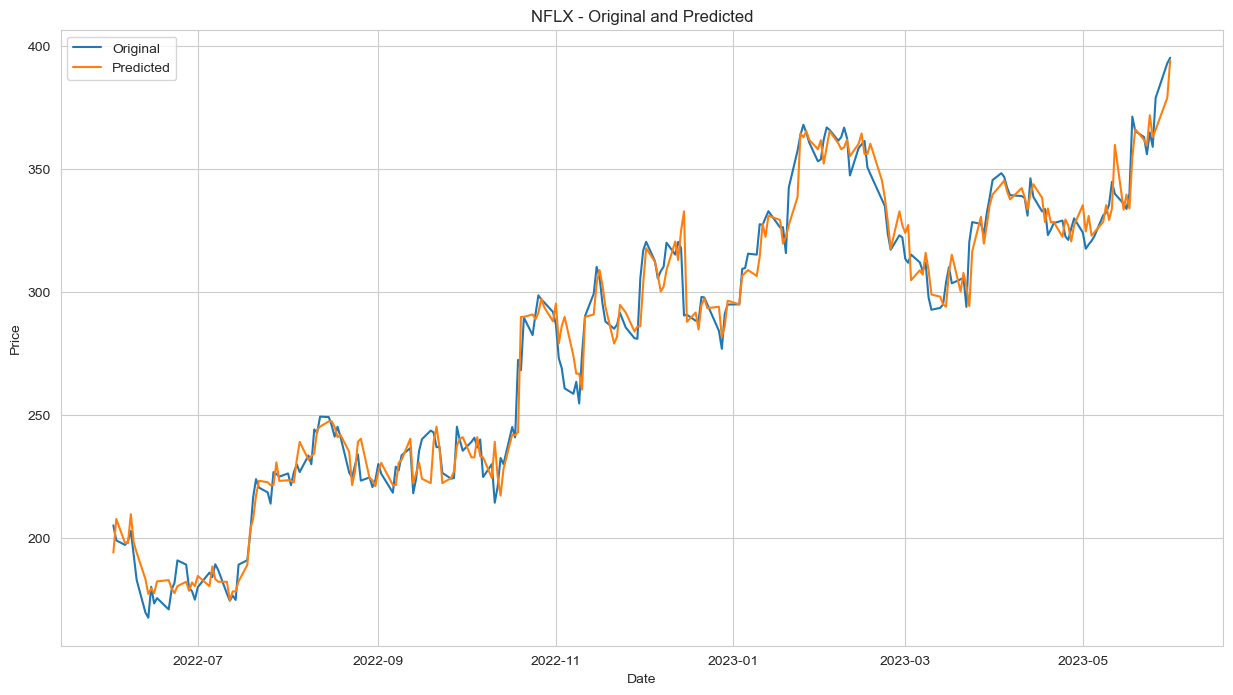

AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
AAPL Predictions with KNeighbors: Mean absolute error: 2.48
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
GOOG Predictions with KNeighbors: Mean absolute error: 2.32
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
MSFT Predictions with KNeighbors: Mean absolute error: 4.69
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
AMZN Predictions with KNeighbors: Mean absolute error: 2.59
NFLX Predictions with RandomForest: Mean absolute error: 8.33
NFLX Predictions with SVR: Mean absolute error: 17.63
NFLX Predictions with KNeighbors: Mean absolute error: 9.39


In [136]:
from sklearn.neighbors import KNeighborsRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    neigh = KNeighborsRegressor(n_neighbors=2)
    neigh.fit(x_train, y_train)

    # Predict the stock prices
    predict = neigh.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)
    
    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['KNeighbors'] = mean_absolute_error

    # Predict all y values from the original x values
    predict_all = neigh.predict(scaler.transform(x))
    # Plot original y values and predicted y values
    plt.figure(figsize=(15, 8))
    plt.plot(df.index[1:], y, label='Original')
    plt.plot(df.index[1:], predict_all, label='Predicted')
    plt.title(f'{ticker} - Original and Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


## Gradient Boosting to Predict Adj Close

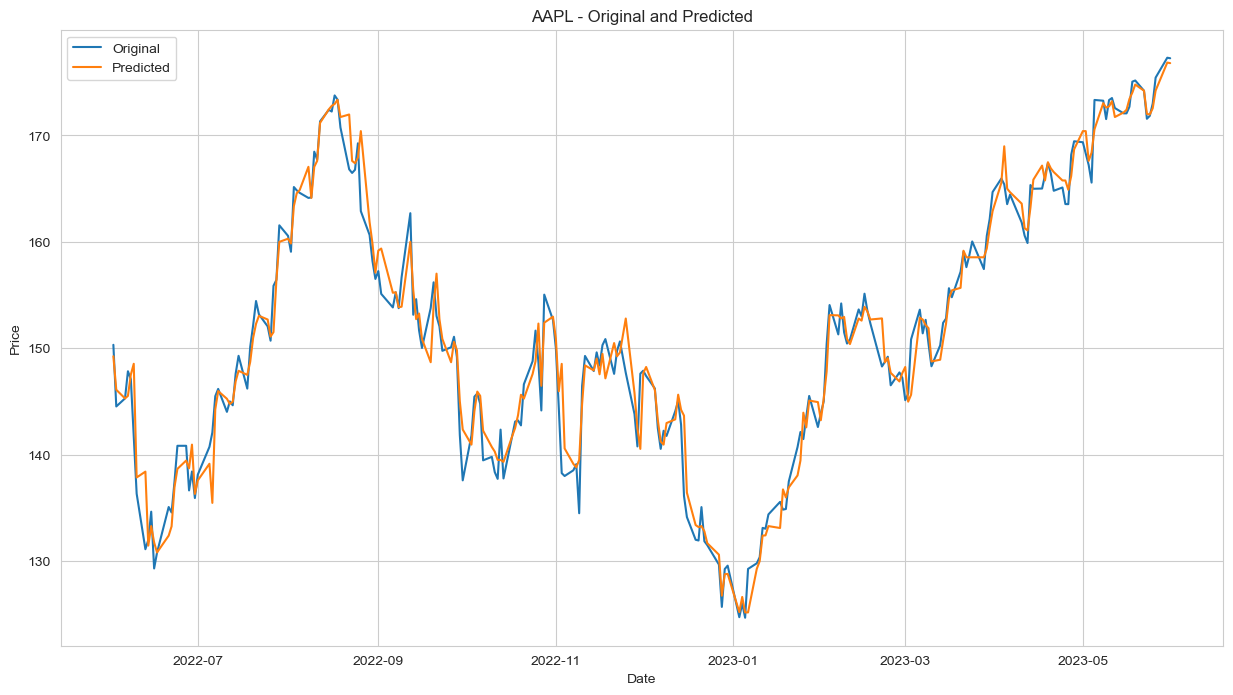

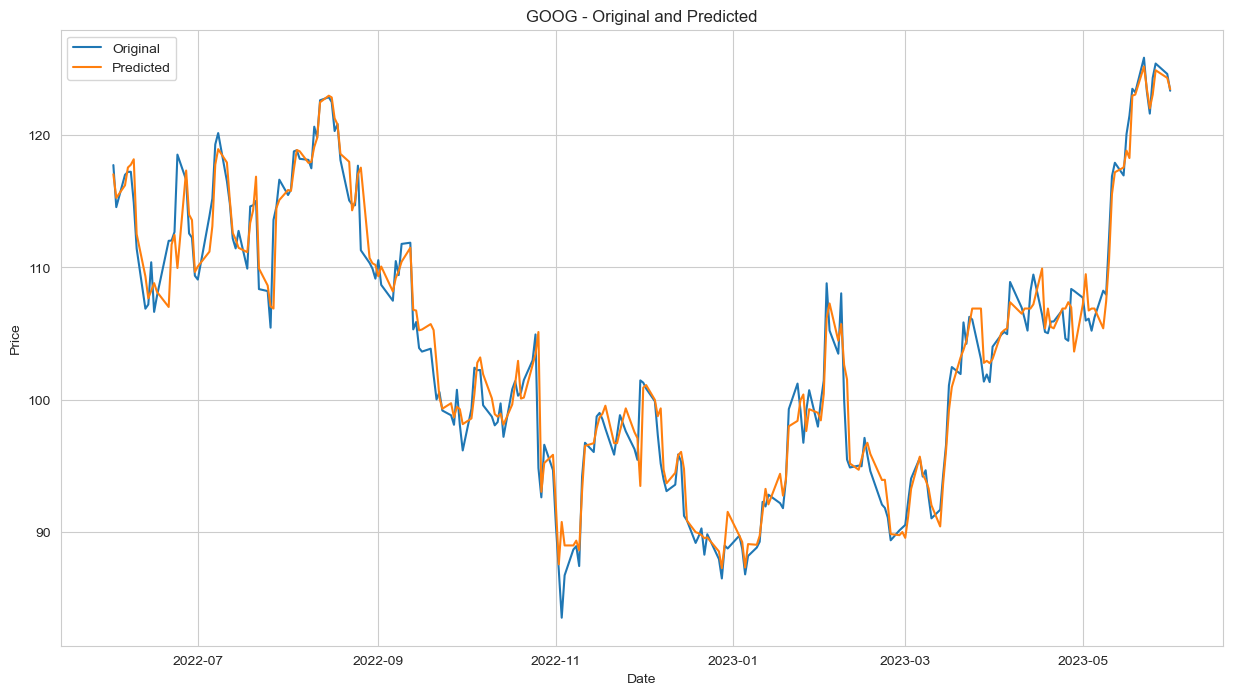

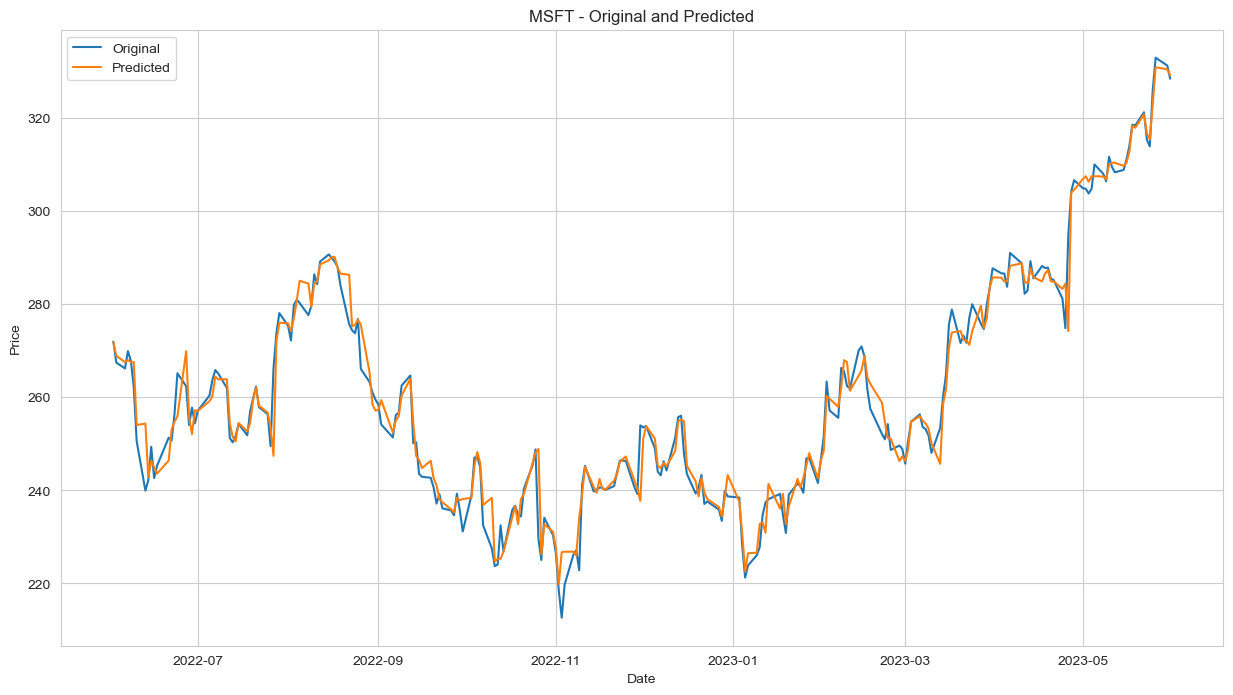

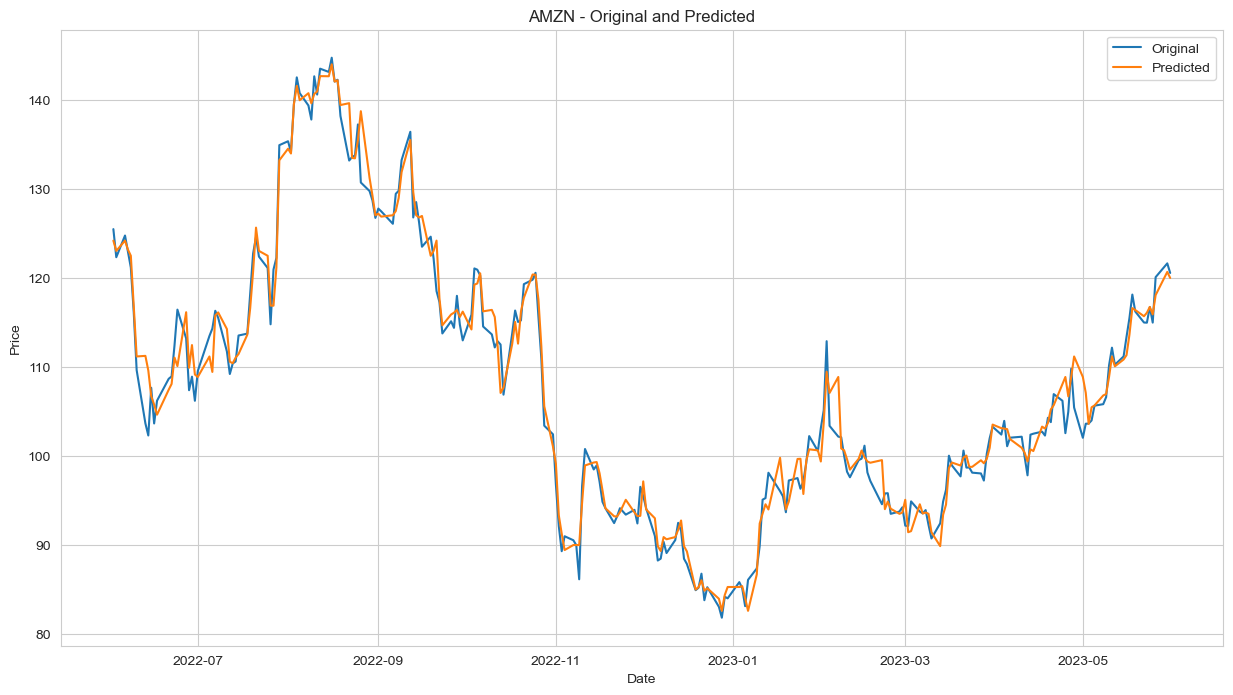

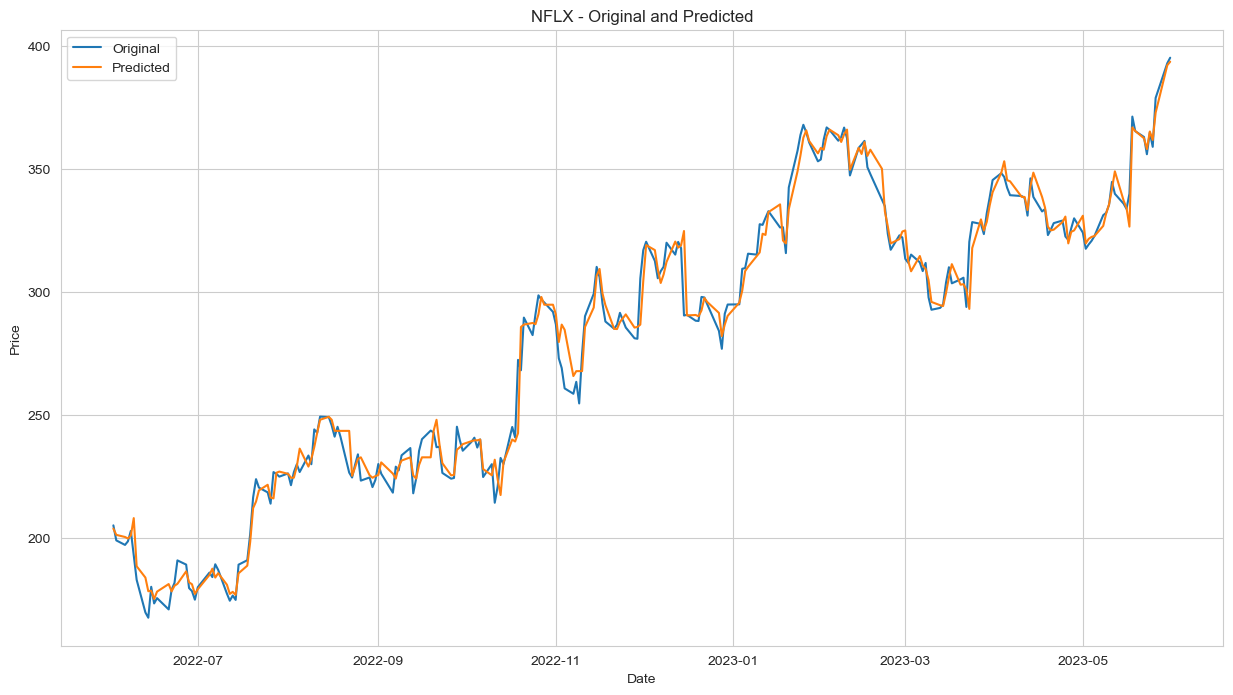

AAPL Predictions with RandomForest: Mean absolute error: 2.51
AAPL Predictions with SVR: Mean absolute error: 2.68
AAPL Predictions with KNeighbors: Mean absolute error: 2.48
AAPL Predictions with GradientBoosting: Mean absolute error: 2.57
GOOG Predictions with RandomForest: Mean absolute error: 2.15
GOOG Predictions with SVR: Mean absolute error: 2.29
GOOG Predictions with KNeighbors: Mean absolute error: 2.32
GOOG Predictions with GradientBoosting: Mean absolute error: 2.28
MSFT Predictions with RandomForest: Mean absolute error: 4.74
MSFT Predictions with SVR: Mean absolute error: 7.91
MSFT Predictions with KNeighbors: Mean absolute error: 4.69
MSFT Predictions with GradientBoosting: Mean absolute error: 5.05
AMZN Predictions with RandomForest: Mean absolute error: 2.57
AMZN Predictions with SVR: Mean absolute error: 2.77
AMZN Predictions with KNeighbors: Mean absolute error: 2.59
AMZN Predictions with GradientBoosting: Mean absolute error: 2.62
NFLX Predictions with RandomForest: 

In [137]:
from sklearn.ensemble import GradientBoostingRegressor

# For each stock
for ticker, df in ticker_data.items():

    # Create x and y
    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    # Split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    # Scale the data using MinMaxScaler
    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Initialize and fit the model
    gb_regressor = GradientBoostingRegressor()
    gb_regressor.fit(x_train, y_train)

    # Predict the stock prices
    predict = gb_regressor.predict(x_test)

    # Calculate mean absolute error
    mean_absolute_error = round(np.mean(np.abs(predict - y_test)), 2)

    # Store the results in the accuracy_results dictionary
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['GradientBoosting'] = mean_absolute_error

    # Predict all y values from the original x values
    predict_all = gb_regressor.predict(scaler.transform(x))
    # Plot original y values and predicted y values
    plt.figure(figsize=(15, 8))
    plt.plot(df.index[1:], y, label='Original')
    plt.plot(df.index[1:], predict_all, label='Predicted')
    plt.title(f'{ticker} - Original and Predicted')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Print the results
for ticker, models in MAE_results.items():
    for model, accuracy in models.items():
        print(f"{ticker} Predictions with {model}: Mean absolute error: {accuracy}")


## LSTM to predict Adj Close

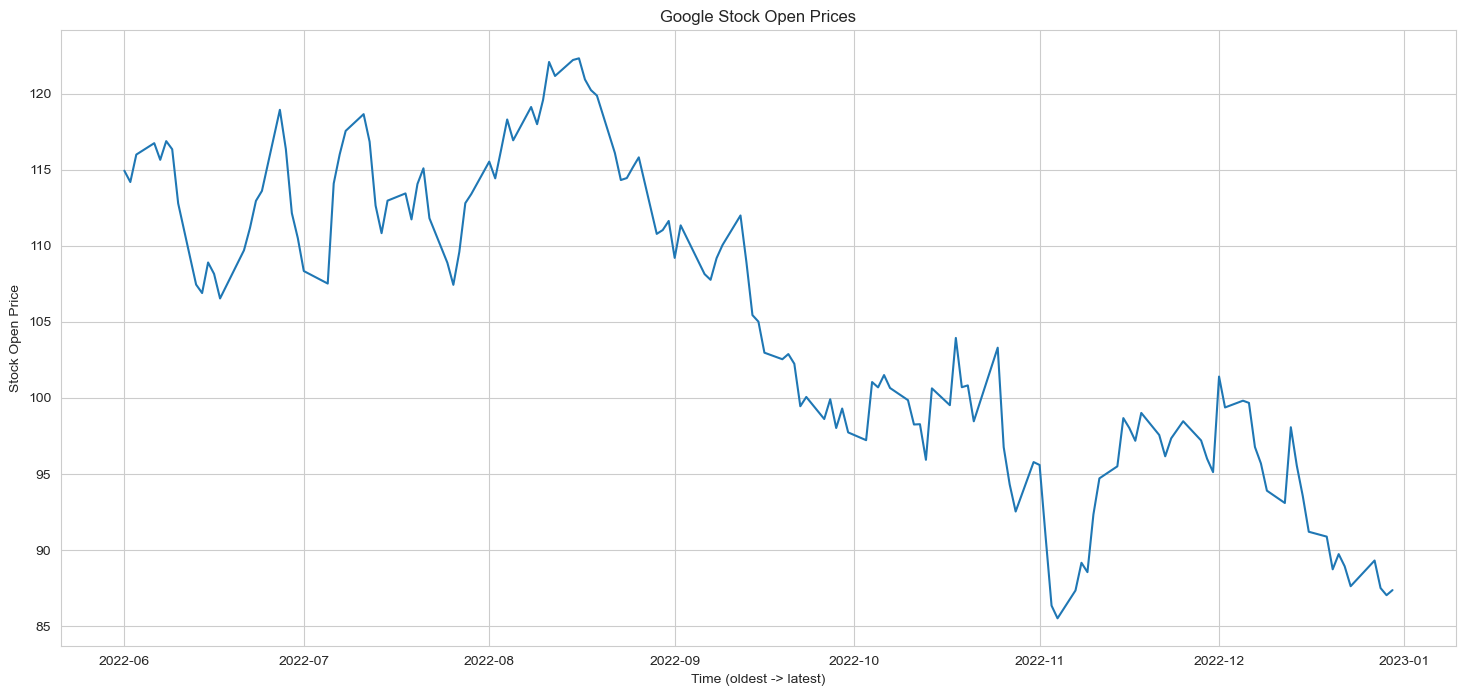

Epoch 1/100
3/3 [==============================] - 4s 60ms/step - loss: 0.1019
Epoch 2/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0340
Epoch 3/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0200
Epoch 4/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0273
Epoch 5/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0257
Epoch 6/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0186
Epoch 7/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0186
Epoch 8/100
3/3 [==============================] - 0s 53ms/step - loss: 0.0174
Epoch 9/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0190
Epoch 10/100
3/3 [==============================] - 0s 69ms/step - loss: 0.0220
Epoch 11/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0165
Epoch 12/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0146
Epoch 13/100
3/3 [==============================]

In [138]:
## Based on New findings, LSTM will be revised as fllwoing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

dataset_train = ticker_data['GOOG'].loc[ticker_data['GOOG'].index <= '2022-12-31']

#print(dataset_train.head())

#keras only takes numpy array
training_set = dataset_train.iloc[:, 1: 2].values
training_set.shape
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

## 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

X_train.shape
y_train.shape

## Data reshaping

X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

X_train.shape

## Create LSTM model and fit the data

regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

## Model Fit
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)



4/4 [==============================] - 1s 15ms/step


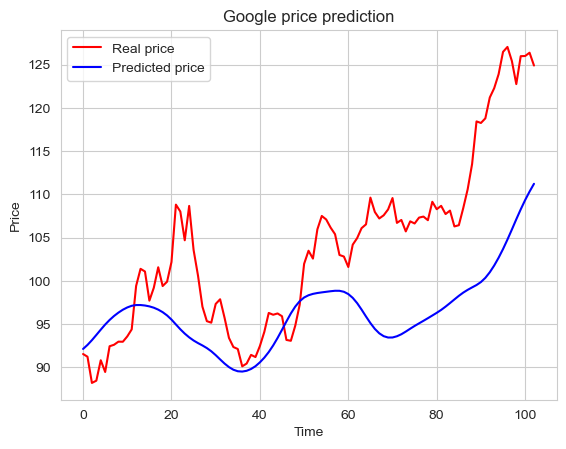

In [139]:
## continue to predict the stock price

## Model evaluation
dataset_test = ticker_data['GOOG'].loc[ticker_data['GOOG'].index > '2022-12-31']
dataset_test.head()
#keras only takes numpy array
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

#vertical concat use 0, horizontal uses 1
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

#reshape data to only have 1 col
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)
len(inputs)

X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

X_test.shape

## prediction

predicted_stock_price = regressor.predict(X_test)
#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)


##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()




4/4 [==============================] - 0s 14ms/step
Root Mean Squared Error: 10.2574


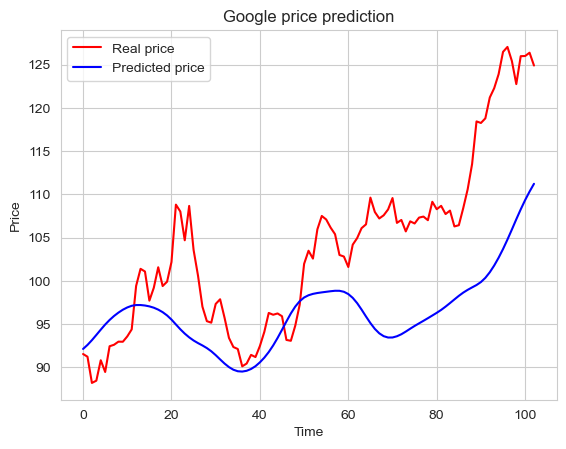

In [140]:
## RESULTS OF ABOVE STUDY
from sklearn.metrics import mean_squared_error

# The rest of your code is above

## prediction
predicted_stock_price = regressor.predict(X_test)

#inverse the scaled value
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('Root Mean Squared Error: {:.4f}'.format(rmse))

##visualize the prediction and real price
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/100
3/3 [==============================] - 4s 62ms/step - loss: 0.1314
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0371
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0299
Epoch 4/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0271
Epoch 5/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0262
Epoch 6/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0237
Epoch 7/100
3/3 [==============================] - 0s 72ms/step - loss: 0.0271
Epoch 8/100
3/3 [==============================] - 0s 60ms/step - loss: 0.0215
Epoch 9/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0232
Epoch 10/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0213
Epoch 11/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0217
Epoch 12/100
3/3 [==============================] - 0s 62ms/step - loss: 0.0195
Epoch 13/100
3/3 [==============================]

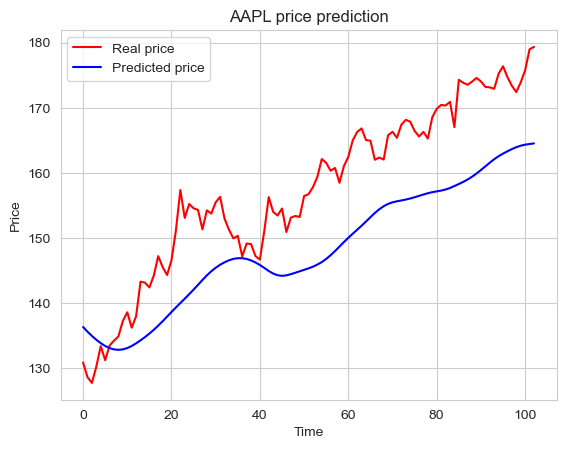

Epoch 1/100
3/3 [==============================] - 4s 65ms/step - loss: 0.1281
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0273
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0246
Epoch 4/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0237
Epoch 5/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0228
Epoch 6/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0180
Epoch 7/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0189
Epoch 8/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0182
Epoch 9/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0164
Epoch 10/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0196
Epoch 11/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0173
Epoch 12/100
3/3 [==============================] - 0s 54ms/step - loss: 0.0168
Epoch 13/100
3/3 [==============================]

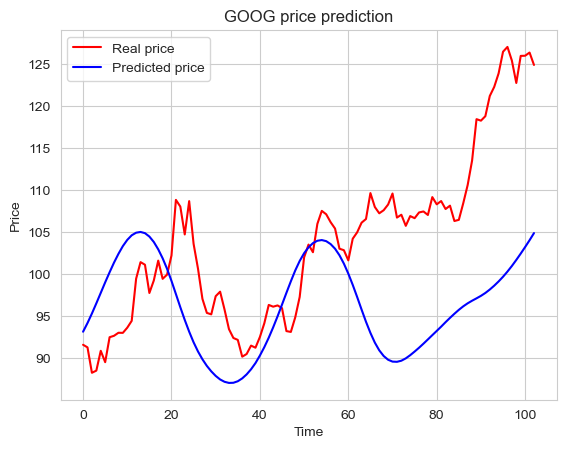

Epoch 1/100
3/3 [==============================] - 4s 65ms/step - loss: 0.1081
Epoch 2/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0320
Epoch 3/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0291
Epoch 4/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0214
Epoch 5/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0245
Epoch 6/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0170
Epoch 7/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0169
Epoch 8/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0166
Epoch 9/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0145
Epoch 10/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0150
Epoch 11/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0160
Epoch 12/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0157
Epoch 13/100
3/3 [==============================]

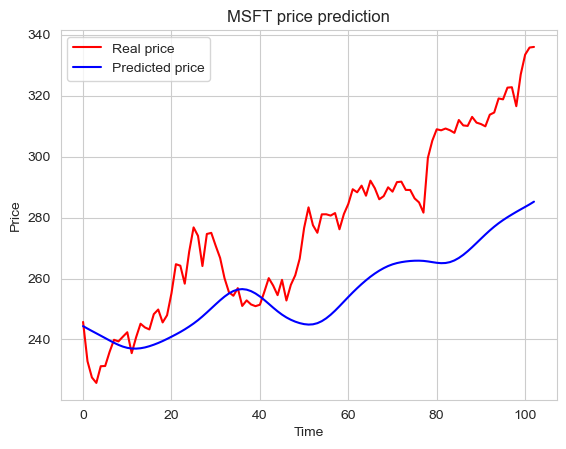

Epoch 1/100
3/3 [==============================] - 4s 63ms/step - loss: 0.1910
Epoch 2/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0648
Epoch 3/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0482
Epoch 4/100
3/3 [==============================] - 0s 55ms/step - loss: 0.0272
Epoch 5/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0315
Epoch 6/100
3/3 [==============================] - 0s 64ms/step - loss: 0.0233
Epoch 7/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0228
Epoch 8/100
3/3 [==============================] - 0s 64ms/step - loss: 0.0186
Epoch 9/100
3/3 [==============================] - 0s 59ms/step - loss: 0.0176
Epoch 10/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0145
Epoch 11/100
3/3 [==============================] - 0s 66ms/step - loss: 0.0101
Epoch 12/100
3/3 [==============================] - 0s 61ms/step - loss: 0.0123
Epoch 13/100
3/3 [==============================]

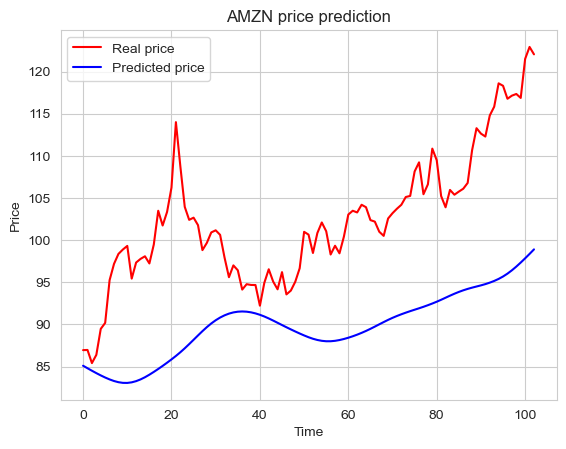

Epoch 1/100
3/3 [==============================] - 4s 63ms/step - loss: 0.3803
Epoch 2/100
3/3 [==============================] - 0s 57ms/step - loss: 0.1665
Epoch 3/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0639
Epoch 4/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0461
Epoch 5/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0413
Epoch 6/100
3/3 [==============================] - 0s 67ms/step - loss: 0.0466
Epoch 7/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0305
Epoch 8/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0266
Epoch 9/100
3/3 [==============================] - 0s 58ms/step - loss: 0.0352
Epoch 10/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0237
Epoch 11/100
3/3 [==============================] - 0s 56ms/step - loss: 0.0324
Epoch 12/100
3/3 [==============================] - 0s 57ms/step - loss: 0.0252
Epoch 13/100
3/3 [==============================]

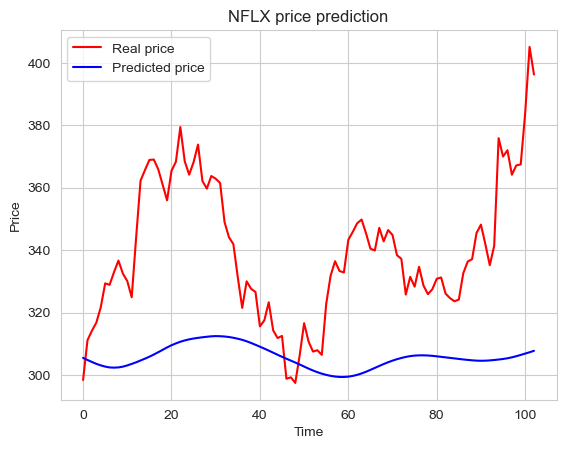

In [148]:
## Iterative way of LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_and_evaluate_LSTM(ticker_data, ticker):
    dataset_train = ticker_data[ticker].loc[ticker_data[ticker].index <= '2022-12-31']

    training_set = dataset_train.iloc[:, 1: 2].values

    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    X_train = []
    y_train = []
    for i in range(60, len(training_set_scaled)):
        X_train.append(training_set_scaled[i-60: i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)

    X_train = np.reshape(X_train, newshape = (X_train.shape[0], X_train.shape[1], 1))

    regressor = Sequential()
    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(rate = 0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(rate = 0.2))

    regressor.add(LSTM(units = 50, return_sequences = False))
    regressor.add(Dropout(rate = 0.2))

    regressor.add(Dense(units = 1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

    dataset_test = ticker_data[ticker].loc[ticker_data[ticker].index > '2022-12-31']
    real_stock_price = dataset_test.iloc[:, 1: 2].values

    dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
    inputs = inputs.reshape(-1, 1)
    inputs = sc.transform(inputs)

    X_test = []
    for i in range(60, len(inputs)):
        X_test.append(inputs[i-60:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    rmse = np.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
    mae = mean_absolute_error(real_stock_price, predicted_stock_price)
    
    return rmse, mae, real_stock_price, predicted_stock_price


for ticker in ticker_data:
    rmse, mae, real_stock_price, predicted_stock_price = train_and_evaluate_LSTM(ticker_data, ticker)
    print(f'{ticker} LSTM Results: RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    
    if ticker not in MAE_results:
        MAE_results[ticker] = {}
    MAE_results[ticker]['LSTM'] = mae
    
    plt.plot(real_stock_price, color = 'red', label = 'Real price')
    plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')
    plt.title(f'{ticker} price prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


## Comparison of different approaches

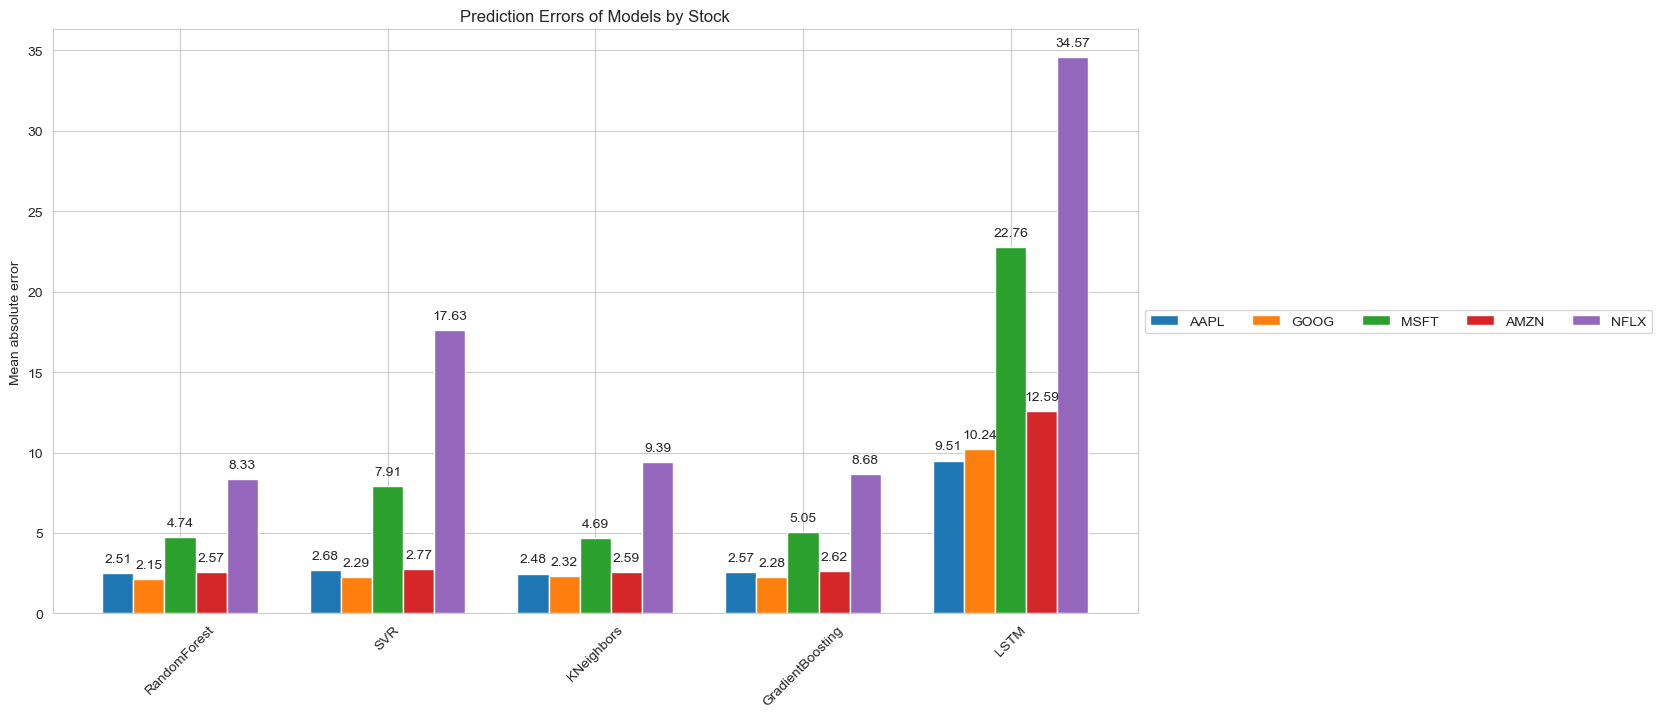

In [149]:
# Define colors for each ticker
tickers = ['AAPL', 'GOOG', 'MSFT', 'AMZN', 'NFLX']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Less intense colors

# Create a color dictionary
color_dict = dict(zip(tickers, colors))

# Convert the results dictionary to a pandas DataFrame
df_results = pd.DataFrame(MAE_results)

# Transpose the DataFrame so that the models are the columns and tickers are the index
df_results = df_results.T

# Define the positions for the bars
bar_width = 0.15
indices = np.arange(len(df_results.columns))

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(14, 8))  # Increase the figure size

# For each model, create a bar plot at a different position
for i, (ticker, accuracies) in enumerate(df_results.iterrows()):
    bars = ax.bar(indices + i*bar_width, accuracies, bar_width, label=ticker, color=color_dict[ticker])
    
    # Add labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 2), ha='center', va='bottom')

# Label the x-axis with the ticker symbols
ax.set_xticks(indices + bar_width * (len(df_results.index)-1) / 2)
ax.set_xticklabels(df_results.columns, rotation=45)  # Rotate the x-axis labels

# Add the legend and labels
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=len(tickers))  # Move the legend to the right side
plt.ylabel('Mean absolute error')
plt.title('Prediction Errors of Models by Stock')
plt.subplots_adjust(bottom=0.15)  # Adjust the bottom of the plot to prevent overlap
plt.show()




From the correlation heatmap, it becomes clear that Microsoft and Amazon share a stronger correlation, and in general
Microsoft maintains a strongest pairwise aggregate correlations compared to the rest of the 'FAANG' companies. Though perhaps expected, it is noteworthy that all five companies pairwise have moderate to strong positive correlation.

## Determining Value from Risk vs. Expected Return
Now we address the question of risk in buying stocks to compare these five companies.

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Define a function to plot stock data
def plot_stock_data(df, ticker):
    plt.figure(figsize=(15, 8))
    df['Adj Close'].plot()
    plt.title(f'{ticker} - Adj Close')
    plt.show()

    plt.figure(figsize=(15, 8))
    df['Volume'].plot()
    plt.title(f'{ticker} - Volume')
    plt.show()

    df[['Adj Close', 'MAvg for 10 days', 'MAvg for 25 days', 'MAvg for 50 days']].plot(figsize=(15, 8))
    plt.title(f'{ticker} - Moving Averages')
    plt.show()

    plt.figure(figsize=(15, 8))
    sns.histplot(df['Daily Return'].dropna(), bins=100, color='red')
    plt.title(f'{ticker} - Daily Return')
    plt.show()

# Define a function to compute and plot correlations
def compute_and_plot_correlations(df):
    correlation_matrix = df.corr()

    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(10, 10))
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

    plt.title('Correlation Matrix of Daily Returns', fontsize=15)
    plt.show()

# Define a function to train and evaluate models
def train_and_evaluate_models(df, ticker):
    accuracy_results = {}

    x = df.iloc[:-1, 0:5].values
    y = df.iloc[1:, 4].values

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=0)

    scaler = MinMaxScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    models = {
        'RandomForest': RandomForestRegressor(n_estimators=500, random_state=42, min_samples_split=2,
                                               min_samples_leaf=1, max_depth=10, bootstrap=True),
        'SVR': SVR(kernel='rbf'),
        'KNeighbors': KNeighborsRegressor(n_neighbors=2),
        'GradientBoosting': GradientBoostingRegressor(),
        'LSTM': Sequential([
            LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
            LSTM(50),
            Dense(1)
        ])
    }

    for model_name, model in models.items():
        model.fit(x_train, y_train)
        predict = model.predict(x_test)
        accuracy = round(100 - np.mean(100 * (abs(predict - y_test) / y_test)), 2)
        accuracy_results[model_name] = accuracy

    return accuracy



From this plot we can see that Microsoft has the highest expected return and the lowest risk -- a sign that it is the best stock to buy at the moment. With its overhaul of its cloud computing sectors and high-profile acquisitions, Microsoft stock is a clear winner here. Netflix's performance is more concerning as it has virtually zero positive expected return along with the highest risk.

We want to model an additional value-at-risk metric in order to assess the value at each risk confidence interval for these 5 companies. Let's try this two ways: bootstrapping and using Monte Carlo-GBM, with Google.

In [143]:
rets_compr.head()

AAPL      GOOG      MSFT      AMZN      NFLX
Date                                                        
2022-06-01       NaN       NaN       NaN       NaN       NaN
2022-06-02  0.016811  0.031620  0.007929  0.031450  0.063138
2022-06-03 -0.038556 -0.027024 -0.016607 -0.025185 -0.029792
2022-06-06  0.005228  0.021355 -0.004703  0.019943 -0.009247
2022-06-07  0.017586  0.001872  0.013954 -0.014344  0.007457

In [144]:
rets_compr['GOOG'].quantile(q=0.05)


-0.033513092014300756

In [145]:
rets_compr['GOOG'].quantile(q=0.01)



-0.058358877147233305

From the empirical quantiles given for both confience intervals, we know that the worst possible loss will not exceed 2.65 percent with 95% confidence and 5.04 percent with 99% confidence.

## Predicting Future Risk and Value of Stocks
We run the Monte Carlo Method on the GBM model to assess the stability and predict the future risk of our stocks. For this component, I'll be analyzing Google's stock.

In [146]:
days = 365

#delta t
dt = 1/365

mu = rets_compr.mean()['GOOG']

sigma = rets_compr.std()['GOOG']


def stock_monte_carlo(start_price,days,mu,sigma):
    
    price = np.zeros(days)
    price[0] = start_price
    
    shock = np.zeros(days)
    drift = np.zeros(days)
    
    for x in range(1,days):
        
        #Shock and drift formulas taken from the Monte Carlo formula
        shock[x] = np.random.normal(loc=mu*dt,scale=sigma*np.sqrt(dt))
        
        drift[x] = mu * dt
        
        #New price = Old price + Old price*(shock+drift)
        price[x] = price[x-1] + (price[x-1] * (drift[x]+shock[x]))
        
    return price


We’re going to run 100 Monte Carlo simulations of Google stocks. Here's the stock's opening values again.



In [147]:
GOOG.head()

NameError: name 'GOOG' is not defined

Text(0.5, 1.0, 'Monte Carlo Analysis for Google')

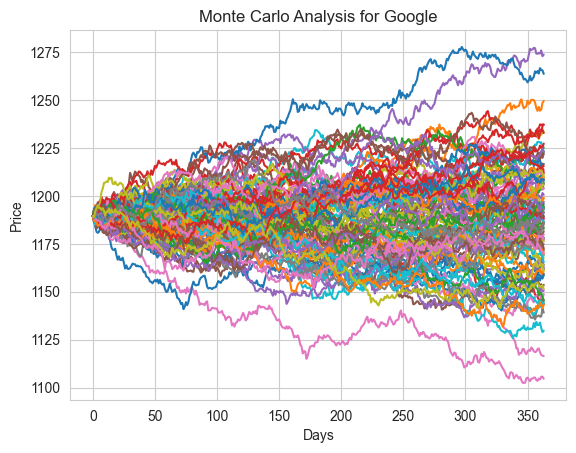

In [ ]:
start_price = 1189.39 #Taken from above

for run in range(1,100):
    plt.plot(stock_monte_carlo(start_price,days,mu,sigma))

plt.xlabel('Days')
plt.ylabel('Price')
plt.title('Monte Carlo Analysis for Google')

Text(0.5, 1.0, 'Final price distribution for Google Stock after 364 days')

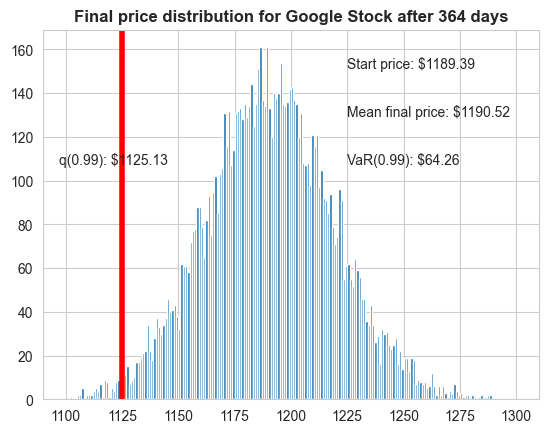

In [ ]:
runs = 10000

simulations = np.zeros(runs)

for run in range(1,runs):
    simulations[run] = stock_monte_carlo(start_price,days,mu,sigma)[days-1]
q = np.percentile(simulations,1)

plt.hist(simulations,bins=200,range = [1100,1300])

plt.figtext(0.6,0.8,s="Start price: $%.2f" %start_price)

plt.figtext(0.6,0.7,"Mean final price: $%.2f" % simulations.mean())

plt.figtext(0.6,0.6,"VaR(0.99): $%.2f" % (start_price -q,))

plt.figtext(0.15,0.6, "q(0.99): $%.2f" % q)

plt.axvline(x=q, linewidth=4, color='r')

plt.title(u"Final price distribution for Google Stock after %s days" %days, weight='bold')

Based off the histogram, we conclude that Google's stock price is very stable (only a $0.11 difference between start and mean final price). The value-at-risk of our investment is $46.42 for maximum low price of $1142.97 with 99% confidence, which is approximately a 3.9% risk compared to the 6.5% we achieved via bootstrapping. 